In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    max_error,
    mean_absolute_percentage_error,
)

sys.path.insert(0, "../../src")
from scripts.DSI.DS import DempsterShafer
from scripts.DSI.DSI_input import DempsterShaferInputHandler


# Load data

In [18]:
import numpy as np
import pandas as pd


def z_score_threshold(probabilities_df, threshold=-1.96):
    # Calculate mean and standard deviation for each segment
    mean_probs = probabilities_df.mean(axis=1)
    std_probs = probabilities_df.std(axis=1)
    print("mean: ", mean_probs, "std: ", std_probs)
    # Calculate z-score for each model's probability
    z_scores = (probabilities_df.subtract(mean_probs, axis=0)).divide(std_probs, axis=0)
    print("z-score: ", z_scores)
    # Eliminate models with z-score below threshold
    eliminated_models = (
        z_scores[z_scores < threshold].dropna(axis=1, how="all").columns.tolist()
    )
    print("exclude: ", eliminated_models)
    return eliminated_models, z_scores


# Example usage
# Assuming 'dsi_ensemble' is a dataframe where each column is a model's probability for a segment
dsi_ensemble = pd.DataFrame(
    {
        "1D-CNN": [0.1],
        "ANN": [0.1],
        "GRU": [0.6],
        "BiLSTM": [0.007],
        "LSTM": [0.192],
        "CNN-LSTM": [0.001],
    }
)
eliminated_models, z_scores = z_score_threshold(dsi_ensemble, threshold=-1.0)
print("Models eliminated based on z-score:", eliminated_models)


from scipy import stats


def t_test_threshold(probabilities_df, expected_mean=1 / 6, alpha=0.05):
    eliminated_models = []

    for model in probabilities_df.columns:
        t_stat, p_value = stats.ttest_1samp(probabilities_df[model], expected_mean)
        print("t-statistic: ", t_stat, "p-value: ", p_value)
        if p_value < alpha and probabilities_df[model].mean() < expected_mean:
            eliminated_models.append(model)

    return eliminated_models


# Example usage
# Assuming 'dsi_ensemble' is a dataframe where each column is a model's probability for a segment
eliminated_models = t_test_threshold(dsi_ensemble, expected_mean=1 / 6, alpha=0.05)
print("Models eliminated based on t-test:", eliminated_models)


import math


def entropy_threshold(probabilities_df, entropy_factor=1.5):
    def entropy(probabilities):
        return -np.sum([p * math.log(p) for p in probabilities if p > 0])

    # Calculate entropy for each segment
    entropy_values = probabilities_df.apply(entropy, axis=1)
    print("entropy: ", entropy_values)
    # Calculate mean entropy
    mean_entropy = entropy_values.mean()
    print("mean entropy: ", mean_entropy)
    # Eliminate models that contribute to entropy more than allowed
    eliminated_models = []
    for model in probabilities_df.columns:
        model_entropy = probabilities_df[model].apply(
            lambda p: -p * math.log(p) if p > 0 else 0
        )
        print("model entropy: ", model_entropy)
        print("condition:", model_entropy.mean(), entropy_factor * mean_entropy)
        if model_entropy.mean() > entropy_factor * mean_entropy:
            eliminated_models.append(model)

    return eliminated_models, entropy_values


# Example usage
eliminated_models, entropy_values = entropy_threshold(dsi_ensemble, entropy_factor=1.5)
print("Models eliminated based on entropy:", eliminated_models)


mean:  0    0.166667
dtype: float64 std:  0    0.223717
dtype: float64
z-score:       1D-CNN       ANN       GRU    BiLSTM      LSTM  CNN-LSTM
0 -0.297995 -0.297995  1.936968 -0.713698  0.113238 -0.740518
exclude:  []
Models eliminated based on z-score: []
t-statistic:  nan p-value:  nan
t-statistic:  nan p-value:  nan
t-statistic:  nan p-value:  nan
t-statistic:  nan p-value:  nan
t-statistic:  nan p-value:  nan
t-statistic:  nan p-value:  nan
Models eliminated based on t-test: []
entropy:  0    1.125503
dtype: float64
mean entropy:  1.1255029661821099
model entropy:  0    0.230259
Name: 1D-CNN, dtype: float64
condition: 0.23025850929940456 1.6882544492731648
model entropy:  0    0.230259
Name: ANN, dtype: float64
condition: 0.23025850929940456 1.6882544492731648
model entropy:  0    0.306495
Name: GRU, dtype: float64
condition: 0.30649537425959444 1.6882544492731648
model entropy:  0    0.034733
Name: BiLSTM, dtype: float64
condition: 0.034732915909487766 1.6882544492731648
model ent

C:\Users\13993807_admin\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\13993807_admin\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [25]:
# # Define the deep learning models
# models = ["1D CNN", "LSTM", "BiLSTM", "CNN-LSTM", "GRU", "ANN"]


# seq_length = 12
# pred_lengths = [6, 12]
# model_names = ["1D-CNN", "ANN", "BiLSTM", "LSTM", "CNN-LSTM", "GRU"]
# models_stats_df = {}

# for pred_length in pred_lengths:
#     pred_length = str(pred_length)
#     models_stats_df[pred_length] = {}
#     for model in model_names:

#         models_stats_filepath = f"../../forecasts/stats/forecast{pred_length}/LIVERPOOL_stats_PM2.5_{seq_length}_{pred_length}_{model}.csv"
#         models_stats_df[pred_length][model] = pd.read_csv(
#             models_stats_filepath, index_col="Segment"
#         )


In [26]:
# # Prepare a list of DataFrames, one for each row across all models
# concatenated_dfs = {}

# for pred_length in pred_lengths:
#     pred_length = str(pred_length)
#     concatenated_dfs[pred_length] = []

#     # Assume each model's DataFrame has the same number of rows (segments)
#     num_segments = models_stats_df[pred_length][model_names[0]].shape[0]

#     for i in range(num_segments):
#         row_data = []
#         for model in model_names:
#             # Extract the i-th row from the DataFrame corresponding to the model
#             row = models_stats_df[pred_length][model].iloc[i].copy()
#             row["Model"] = model  # Add model name to the row
#             row_data.append(row)

#         # Combine rows from all models for the i-th segment into a single DataFrame
#         combined_df = pd.DataFrame(row_data)
#         combined_df.set_index("Model", inplace=True)
#         concatenated_dfs[pred_length].append(combined_df)

# # Print the combined DataFrame for a specific prediction length (e.g., 6 hours)
# print(concatenated_dfs["6"][0])


# Ensemble

In [27]:
def calculate_statistics(y_true, y_pred):
    stats = {}
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    pearson_r, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    max_error_value = max_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # return rmse, mae, pearson_r, r2, max_error_value, mape
    stats["RMSE"] = rmse
    stats["Pearson_r"] = pearson_r
    stats["MAE"] = mae
    stats["R2"] = r2
    stats["Max_Error"] = max_error_value
    stats["MAPE"] = mape
    return stats


import pandas as pd


def evaluate_forecast_models(forecast_dict, observation_df):
    """
    Evaluate multiple forecast models against actual observations on a row-by-row basis.

    Args:
    - forecast_dict: Dictionary of forecasted values with the format:
        {"model1": forecast_df1, "model2": forecast_df2, ...}
    - observation_df: DataFrame with the actual observed values, indexed by time.

    Returns:
    - A dictionary with each model name as key and a DataFrame of calculated statistics for each row as value.
    """
    model_stats = {}  # Initialize a dictionary to store stats for each model
    forecast_length = observation_df.shape[1]

    for model_name, forecast_df in forecast_dict.items():
        if forecast_df.shape[1] < observation_df.shape[1]:
            raise ValueError(
                f"Forecast length ({forecast_df.shape[1]}) and observation length ({observation_df.shape[1]}) do not match."
            )
        else:
            print(
                f"Forecast length ({forecast_df.shape[1]}) and observation length ({observation_df.shape[1]}) match."
            )

        # Align forecast and observation data based on DateTimeIndex
        common_index = forecast_df.index.intersection(observation_df.index)
        print("Common Index: ", common_index)

        # Ensure forecast values cover the desired observation period
        relevant_forecast = forecast_df.loc[common_index].iloc[:, :forecast_length]
        relevant_observation = observation_df.loc[common_index].iloc[
            :, :forecast_length
        ]

        # Initialize a DataFrame to hold stats for each row of forecasts
        stats_list = []

        # Iterate over each row (time-step) in relevant_forecast and relevant_observation
        for i in range(relevant_forecast.shape[0]):
            forecast_row = relevant_forecast.iloc[i, :]
            observation_row = relevant_observation.iloc[i, :]

            # Calculate statistics for each row
            stats = calculate_statistics(observation_row.values, forecast_row.values)
            stats_list.append(stats)

        # Create a DataFrame for this model's statistics
        model_stats_df = pd.DataFrame(stats_list, index=relevant_forecast.index)
        model_stats[model_name] = model_stats_df  # Store DataFrame in the dictionary

    return model_stats


# Example usage
# forecasts = {"6": {"LSTM": lstm_forecast, "CNN": cnn_forecast}, "12": {"LSTM": lstm_forecast_12, "CNN": cnn_forecast_12}}
# observations = actual_observations
# stats = calculate_statistics(forecasts, observations)


In [28]:
# # Define the deep learning models

seq_length = 12
pred_lengths = [6, 12]
model_names = ["1D-CNN", "ANN", "BiLSTM", "LSTM", "CNN-LSTM", "GRU"]
models_forecast_df = {}
models_stats_df = {}

for pred_length in pred_lengths:
    pred_length = str(pred_length)
    models_forecast_df[pred_length] = {}
    for model in model_names:

        models_forecast_filepath = f"../../forecasts/forecast{pred_length}/LIVERPOOL_forecast_PM2.5_{seq_length}_{pred_length}_{model}.csv"
        models_forecast_df[pred_length][model] = pd.read_csv(
            models_forecast_filepath, index_col="Segment"
        )
    observation_filepath = f"../../forecasts/test/test_data_forecast{pred_length}.csv"
    observation_df = pd.read_csv(observation_filepath, index_col="Segment")
    # observation_df.index = pd.to_datetime(observation_df.index)
    # early = int(int(pred_length) / 2)
    early = int(pred_length)

    print(early)
    observation_df = observation_df.iloc[:, :early]
    models_stats_df[pred_length] = evaluate_forecast_models(
        models_forecast_df[pred_length], observation_df
    )
print(models_stats_df)


6
Forecast length (6) and observation length (6) match.
Common Index:  Index(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       ...
       'S5015', 'S5016', 'S5017', 'S5018', 'S5019', 'S5020', 'S5021', 'S5022',
       'S5023', 'S5024'],
      dtype='object', name='Segment', length=5024)


KeyboardInterrupt: 

In [ ]:
for forecast_hour, forecasts in models_stats_df.items():
    for forecast_model, forecast_stats in forecasts.items():
        forecast_stats.to_csv(
            f"../../forecasts/stats/partial/forecast_{forecast_hour}/LIVERPOOL_stats_PM2.5_{seq_length}_{forecast_hour}_{forecast_model}.csv"
        )


## Dummy test

In [ ]:
# # Function to generate dummy forecast and observation data
# def generate_dummy_data(start_time, periods, freq, num_models, forecast_length):
#     # Create a DateTimeIndex
#     time_index = pd.date_range(start=start_time, periods=periods, freq=freq)

#     # Generate random data for forecasts
#     forecast_dict = {}
#     for forecast_hour in [6, 12, 24]:  # Assuming different forecast lengths
#         models = {}
#         for i in range(1, num_models + 1):
#             model_name = f"Model_{i}"
#             # Generate forecast values with slight variations per model
#             forecast_values = np.random.rand(periods) * 100 + i * 5
#             models[model_name] = pd.DataFrame(
#                 forecast_values, index=time_index, columns=["forecast"]
#             )
#         forecast_dict[str(forecast_hour)] = models

#     # Generate observation data
#     observation_values = np.random.rand(periods) * 100
#     observation_df = pd.DataFrame(
#         observation_values, index=time_index, columns=["observed"]
#     )

#     return forecast_dict, observation_df


# # Parameters
# start_time = "2024-08-01 00:00:00"
# periods = 48  # Total number of hours
# freq = "H"  # Hourly data
# num_models = 3  # Number of models
# forecast_length = 6  # Number of hours to evaluate

# # Generate dummy data
# forecast_dict, observation_df = generate_dummy_data(
#     start_time, periods, freq, num_models, forecast_length
# )

# # Test the evaluate_forecast_models function
# evaluation_results = evaluate_forecast_models(forecast_dict, observation_df)

# # Print the evaluation results
# print("Evaluation Results:", evaluation_results)
# for forecast_hour, model_stats in evaluation_results.items():
#     print(f"\nForecast Hour: {forecast_hour}")
#     for model_name, stats in model_stats.items():
#         print(
#             f"  {model_name} -> RMSE: {stats['RMSE']:.3f}, Pearson_r: {stats['Pearson_r']:.3f}"
#         )


# Real test

In [2]:
seq_length = 12
pred_lengths = [6, 12]
model_names = ["1D-CNN", "ANN", "BiLSTM", "LSTM", "CNN-LSTM", "GRU"]
# model_names = ["1D-CNN", "ANN", "LSTM", "CNN-LSTM", "GRU"]  # model_id = 1
# model_names = ["1D-CNN", "ANN", "CNN-LSTM", "GRU"]  # model_id = 2
# model_names = ["1D-CNN", "ANN", "GRU"]  # model_id = 3


# model_names = ["1D-CNN", "LSTM", "BiLSTM", "CNN-LSTM", "GRU", "ANN"]

# model_names = ["1D-CNN", "ANN", "BiLSTM", "LSTM", "CNN-LSTM"]
# model_names = ["1D-CNN", "ANN", "BiLSTM", "LSTM"]
# model_names = ["LSTM", "1D-CNN", "ANN", "BiLSTM"]

model_id = 3

models_stats_df = {}
models_stats_complete_df = {}
models_stats_partial_df = {}

for pred_length in pred_lengths:
    pred_length = str(pred_length)
    models_stats_complete_df[pred_length] = {}
    models_stats_partial_df[pred_length] = {}

    for model in model_names:

        models_stats_complete_filepath = f"../../forecasts/stats/complete/forecast{pred_length}/LIVERPOOL_stats_PM2.5_{seq_length}_{pred_length}_{model}.csv"
        models_stats_complete_df[pred_length][model] = pd.read_csv(
            models_stats_complete_filepath, index_col="Segment"
        )

        models_stats_partial_filepath = f"../../forecasts/stats/partial/forecast{pred_length}/LIVERPOOL_stats_PM2.5_{seq_length}_{pred_length}_{model}.csv"
        models_stats_partial_df[pred_length][model] = pd.read_csv(
            models_stats_partial_filepath, index_col="Segment"
        )


In [3]:
# Prepare a list of DataFrames, one for each row across all models (complete)
concatenated_complete_dfs = {}

for pred_length in pred_lengths:
    pred_length = str(pred_length)
    concatenated_complete_dfs[pred_length] = []

    # Assume each model's DataFrame has the same number of rows (segments)
    num_segments = models_stats_complete_df[pred_length][model_names[0]].shape[0]

    for i in range(num_segments):
        row_data = []
        for model in model_names:
            # Extract the i-th row from the DataFrame corresponding to the model
            row = models_stats_complete_df[pred_length][model].iloc[i].copy()
            row["Model"] = model  # Add model name to the row
            row_data.append(row)

        # Combine rows from all models for the i-th segment into a single DataFrame
        combined_df = pd.DataFrame(row_data)
        combined_df.set_index("Model", inplace=True)
        concatenated_complete_dfs[pred_length].append(combined_df)

# Print the combined DataFrame for a specific prediction length (e.g., 6 hours)
print(concatenated_complete_dfs["6"][0])


# Prepare a list of DataFrames, one for each row across all models (partial)
concatenated_partial_dfs = {}

for pred_length in pred_lengths:
    pred_length = str(pred_length)
    concatenated_partial_dfs[pred_length] = []

    # Assume each model's DataFrame has the same number of rows (segments)
    num_segments = models_stats_partial_df[pred_length][model_names[0]].shape[0]

    for i in range(num_segments):
        row_data = []
        for model in model_names:
            # Extract the i-th row from the DataFrame corresponding to the model
            row = models_stats_partial_df[pred_length][model].iloc[i].copy()
            row["Model"] = model  # Add model name to the row
            row_data.append(row)

        # Combine rows from all models for the i-th segment into a single DataFrame
        combined_df = pd.DataFrame(row_data)
        combined_df.set_index("Model", inplace=True)
        concatenated_partial_dfs[pred_length].append(combined_df)

# Print the combined DataFrame for a specific prediction length (e.g., 6 hours)
print(concatenated_partial_dfs["6"][0])


              RMSE  Pearson_r       MAE        R2  Max_Error      MAPE
Model                                                                 
1D-CNN    4.498649   0.339206  3.814761 -0.203519   7.071047  1.421250
ANN       5.280954  -0.716000  4.418427 -0.658493   8.916636  1.672078
BiLSTM    3.626185   0.765272  3.279431  0.218032   4.536976  0.943869
LSTM      3.924848   0.513019  3.596564  0.083918   5.545056  0.983884
CNN-LSTM  3.596112   0.794063  3.339676  0.230949   4.833228  0.967269
GRU       4.197359  -0.181845  3.966330 -0.047710   5.304257  1.086696
              RMSE  Pearson_r       MAE         R2  Max_Error      MAPE
Model                                                                  
1D-CNN    6.023866   0.998942  5.830424 -12.200594   7.071047  2.681734
ANN       7.188422  -0.303278  6.900329 -17.797927   8.916636  3.168598
BiLSTM    3.558624  -0.990701  2.922005  -3.606881   4.536976  1.555328
LSTM      3.591772  -0.980268  3.104937  -3.693105   4.627238  1.596231


# DSI

## Create matrices

In [23]:
c = ["1dcnn", "cnn-lstm", "lstm", "gru", "ann", "bilstm"]
b = pd.DataFrame(
    {
        "1dcnn": [1, 2, 3, 4, 5, 6],
        "cnn-lstm": [1, 2, 3, 4, 5, 6],
        "lstm": [1, 2, 3, 4, 5, 6],
        "gru": [1, 2, 3, 4, 5, 6],
        "ann": [1, 2, 3, 4, 5, 6],
        "bilstm": [1, 2, 3, 4, 5, 6],
    }
)
a = pd.DataFrame(
    {
        "1dcnn": [1, 2, 3, 4, 5, 6],
        "cnn-lstm": [1, 2, 3, 4, 5, 6],
        "lstm": [1, 2, 3, 4, 5, 6],
    }
)
a.columns = c


ValueError: Length mismatch: Expected axis has 3 elements, new values have 6 elements

In [25]:
# Define scenarios
scenarios = {
    1: {"sampling_matrix": np.array([[0, 1]]), "parameters": ["RMSE", "Pearson_r"]},
    2: {
        "sampling_matrix": np.array([[0, 1, 1]]),
        "parameters": ["RMSE", "Pearson_r", "R2"],
    },
    3: {
        "sampling_matrix": np.array([[0, 0, 1]]),
        "parameters": ["RMSE", "MAE", "Pearson_r"],
    },
    4: {"sampling_matrix": np.array([[0, 1]]), "parameters": ["RMSE", "R2"]},
    5: {"sampling_matrix": np.array([[0, 0, 1]]), "parameters": ["RMSE", "MAE", "R2"]},
    6: {
        "sampling_matrix": np.array([[0, 0, 1, 1]]),
        "parameters": ["RMSE", "MAE", "Pearson_r", "R2"],
    },
}

print("Model names: :", model_names)


# Function to eliminate the lowest-ranked model
def eliminate_lowest_ranked_model(result_df, current_reference_matrix, model_names):
    # Find the model with the lowest probability
    lowest_model = result_df.idxmin(axis=1).values[0]  # Model with lowest probability
    print(f"Eliminating model: {lowest_model}")

    # Remove the row corresponding to the lowest model from segment_reference_matrix
    current_reference_matrix = current_reference_matrix.drop(lowest_model, axis=0)

    # Remove the model from the list of model names
    model_names.remove(lowest_model)

    return current_reference_matrix, model_names


# Main loop with model elimination and concatenation
for scenario_id, config in scenarios.items():
    sampling_matrix = config["sampling_matrix"]
    parameters = config["parameters"]

    # Convert the sampling matrix to a DataFrame
    sampling_matrix_df = pd.DataFrame(sampling_matrix, columns=parameters)

    # Perform Dempster-Shafer analysis for both partial and complete evaluations
    for evaluation_mode in ["complete", "partial"]:
        dsi_results = {}

        for pred_length in pred_lengths:
            pred_length = str(pred_length)
            if evaluation_mode == "complete":
                current_reference_matrix = concatenated_complete_dfs[pred_length]
            else:
                current_reference_matrix = concatenated_partial_dfs[pred_length]

            dsi_results[pred_length] = pd.DataFrame()

            # Loop through each segment
            for segment_index in current_reference_matrix:
                segment_reference_matrix = segment_index[parameters]
                print("segment: ", segment_reference_matrix)

                # Initialize model names for this segment
                test_hypotheses = (
                    segment_reference_matrix.index.values.tolist()
                )  # Or replace 'parameters' with the specific model names
                result = pd.DataFrame()
                while len(test_hypotheses) >= 3:  # Continue until 3 models are left
                    # Dempster-Shafer handler
                    ds_handler = DempsterShaferInputHandler(
                        segment_reference_matrix, sampling_matrix_df
                    )
                    ds_handler.normalize_data()
                    normalized_reference = ds_handler.get_normalized_reference_matrix()
                    normalized_sampling = ds_handler.get_normalized_sampling_matrix()

                    # Dempster-Shafer Analysis
                    normalized_reference_np = normalized_reference.to_numpy()
                    normalized_sampling_np = normalized_sampling.to_numpy()
                    is_uncertain = "Uncertain" in test_hypotheses

                    dsi = DempsterShafer(
                        normalized_reference_np, normalized_sampling_np, is_uncertain
                    )
                    # test_hypotheses = list(model_names)
                    dsi.hypothesis_order(test_hypotheses)
                    result = dsi.result()

                    # Eliminate the lowest-ranked model
                    segment_reference_matrix, test_hypotheses = (
                        eliminate_lowest_ranked_model(
                            result, segment_reference_matrix, test_hypotheses
                        )
                    )

                # Add the final result (after elimination) to the dsi_results
                # Align with other results by filling missing models with 0s
                print("results: ", result)
                # result.columns = model_names  # Rename columns to remaining model names
                aligned_result = result.reindex(
                    columns=model_names, fill_value=0
                )  # Align with all models
                print("aligned: ", aligned_result)
                dsi_results[pred_length] = pd.concat(
                    [dsi_results[pred_length], aligned_result]
                )

        # Save results
        for key, value in dsi_results.items():
            row_indices = [f"S{i+1}" for i in range(value.shape[0])]
            value.index = row_indices
            value.index.name = "Segment"
            value = value.apply(pd.to_numeric, errors="coerce")
            value["Selected"] = value.idxmax(axis=1)
            early = key

            if evaluation_mode == "complete":
                value.to_csv(
                    f"../../fusion/complete/forecast{key}/dsi_ensemble_{early}_{key}_ID{scenario_id}_v{model_id}_e0.csv",
                    header=True,
                    index=True,
                )
            else:
                early = int(int(key) / 2)
                value.to_csv(
                    f"../../fusion/partial/forecast{key}/dsi_ensemble_{early}_{key}_ID{scenario_id}_v{model_id}_e0.csv",
                    header=True,
                    index=True,
                )

# dsi_results[pred_length] will now contain aligned results for all segments and rounds.


In [31]:
# Define scenarios
scenarios = {
    1: {"sampling_matrix": np.array([[0, 1]]), "parameters": ["RMSE", "Pearson_r"]},
    2: {
        "sampling_matrix": np.array([[0, 1, 1]]),
        "parameters": ["RMSE", "Pearson_r", "R2"],
    },
    3: {
        "sampling_matrix": np.array([[0, 0, 1]]),
        "parameters": ["RMSE", "MAE", "Pearson_r"],
    },
    4: {"sampling_matrix": np.array([[0, 1]]), "parameters": ["RMSE", "R2"]},
    5: {"sampling_matrix": np.array([[0, 0, 1]]), "parameters": ["RMSE", "MAE", "R2"]},
    6: {
        "sampling_matrix": np.array([[0, 0, 1, 1]]),
        "parameters": ["RMSE", "MAE", "Pearson_r", "R2"],
    },
}

test_hypotheses = list(model_names)
print(test_hypotheses)

# Loop through each scenario
for scenario_id, config in scenarios.items():
    sampling_matrix = config["sampling_matrix"]
    parameters = config["parameters"]

    # Convert the sampling matrix to a DataFrame
    sampling_matrix_df = pd.DataFrame(sampling_matrix, columns=parameters)

    # Perform Dempster-Shafer analysis for both partial and complete evaluations
    for evaluation_mode in ["complete", "partial"]:
        dsi_results = {}

        for pred_length in pred_lengths:
            pred_length = str(pred_length)
            if evaluation_mode == "complete":
                current_reference_matrix = concatenated_complete_dfs[pred_length]
            else:
                current_reference_matrix = concatenated_partial_dfs[pred_length]

            dsi_results[pred_length] = pd.DataFrame()

            # Loop through each segment
            for segment_index in current_reference_matrix:

                segment_reference_matrix = segment_index[parameters]

                # Dempster-Shafer handler
                ds_handler = DempsterShaferInputHandler(
                    segment_reference_matrix, sampling_matrix_df
                )
                ds_handler.normalize_data()
                normalized_reference = ds_handler.get_normalized_reference_matrix()
                normalized_sampling = ds_handler.get_normalized_sampling_matrix()

                # Dempster-Shafer Analysis
                normalized_reference_np = normalized_reference.to_numpy()
                normalized_sampling_np = normalized_sampling.to_numpy()
                is_uncertain = "Uncertain" in test_hypotheses

                dsi = DempsterShafer(
                    normalized_reference_np, normalized_sampling_np, is_uncertain
                )
                test_hypotheses = list(model_names)
                print(test_hypotheses)
                dsi.hypothesis_order(test_hypotheses)
                result = dsi.result()
                dsi_results[pred_length] = pd.concat((dsi_results[pred_length], result))

        # Save results
        for key, value in dsi_results.items():
            row_indices = [f"S{i+1}" for i in range(value.shape[0])]
            value.index = row_indices
            value.index.name = "Segment"
            value = value.apply(pd.to_numeric, errors="coerce")
            value["Selected"] = value.idxmax(axis=1)
            early = key

            if evaluation_mode == "complete":
                value.to_csv(
                    f"../../fusion/complete/forecast{key}/dsi_ensemble_{early}_{key}_ID{scenario_id}_v{model_id}_e0.csv",
                    header=True,
                    index=True,
                )
            else:
                early = int(int(key) / 2)
                value.to_csv(
                    f"../../fusion/partial/forecast{key}/dsi_ensemble_{early}_{key}_ID{scenario_id}_v{model_id}_e0.csv",
                    header=True,
                    index=True,
                )


['1D-CNN', 'ANN', 'GRU']


# Stats

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef,
    jaccard_score,
    classification_report,
)
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency, fisher_exact

# Initialize empty DataFrames for storing model counts and statistics
model_counts_complete = pd.DataFrame()
model_counts_partial = pd.DataFrame()

# DataFrames to store statistics for each prediction length
stats_df_complete = pd.DataFrame(
    columns=[
        "Scenario",
        "Kappa",
        "McNemar p-value",
        "Fisher p-value",
        "Chi-Square p-value",
        "MCC",
        "Jaccard",
    ]
)
stats_df_partial = pd.DataFrame(
    columns=[
        "Scenario",
        "Kappa",
        "McNemar p-value",
        "Fisher p-value",
        "Chi-Square p-value",
        "MCC",
        "Jaccard",
    ]
)

for scenario_id, config in scenarios.items():
    for pred_length in pred_lengths:

        # Complete Evaluation
        dsi_ensemble_complete = pd.read_csv(
            f"../../fusion/complete/forecast{pred_length}/dsi_ensemble_{pred_length}_{pred_length}_ID{scenario_id}_v{model_id}.csv",
            index_col="Segment",
        )
        selected_complete = dsi_ensemble_complete["Selected"]
        selected_complete_counts = selected_complete.value_counts()

        # Add counts to the model_counts_complete DataFrame
        model_counts_complete[f"Scenario_{scenario_id}_Complete_{pred_length}h"] = (
            selected_complete_counts
        )

        # Partial Evaluation
        dsi_ensemble_partial = pd.read_csv(
            f"../../fusion/partial/forecast{pred_length}/dsi_ensemble_{int(int(pred_length)/2)}_{pred_length}_ID{scenario_id}_v{model_id}.csv",
            index_col="Segment",
        )
        selected_partial = dsi_ensemble_partial["Selected"]
        selected_partial_counts = selected_partial.value_counts()

        # Add counts to the model_counts_partial DataFrame
        model_counts_partial[f"Scenario_{scenario_id}_Partial_{pred_length}h"] = (
            selected_partial_counts
        )

        # Confusion Matrix and Statistical Analysis
        labels = sorted(list(set(selected_complete) | set(selected_partial)))
        cm = confusion_matrix(selected_complete, selected_partial, labels=labels)
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        # Cohen's Kappa
        kappa = cohen_kappa_score(selected_complete, selected_partial)

        # McNemar's Test
        result = mcnemar(cm)
        mcnemar_p = result.pvalue

        # Fisher's Exact Test (only for 2x2 confusion matrix)
        fisher_p = None
        if cm.shape == (2, 2):
            _, fisher_p = fisher_exact(cm)

        # Chi-Square Test
        cm_float = cm.astype(float) + np.ones(cm.shape) * 1e-6  # Avoid zero counts
        chi2, chi2_p, _, _ = chi2_contingency(cm_float)

        # Matthews Correlation Coefficient (MCC)
        mcc = matthews_corrcoef(selected_complete, selected_partial)

        # Jaccard Similarity Index
        jaccard = jaccard_score(selected_complete, selected_partial, average="macro")

        # Store statistics for complete evaluation in the DataFrame
        stats_df_complete = pd.concat(
            [
                stats_df_complete,
                pd.DataFrame(
                    {
                        "Scenario": [f"Scenario_{scenario_id}_Complete_{pred_length}h"],
                        "Kappa": [kappa],
                        "McNemar p-value": [mcnemar_p],
                        "Fisher p-value": [fisher_p if fisher_p is not None else "N/A"],
                        "Chi-Square p-value": [chi2_p],
                        "MCC": [mcc],
                        "Jaccard": [jaccard],
                    }
                ),
            ],
            ignore_index=True,
        )

        # Store statistics for partial evaluation in the DataFrame using pd.concat
        stats_df_partial = pd.concat(
            [
                stats_df_partial,
                pd.DataFrame(
                    {
                        "Scenario": [f"Scenario_{scenario_id}_Partial_{pred_length}h"],
                        "Kappa": [kappa],
                        "McNemar p-value": [mcnemar_p],
                        "Fisher p-value": [fisher_p if fisher_p is not None else "N/A"],
                        "Chi-Square p-value": [chi2_p],
                        "MCC": [mcc],
                        "Jaccard": [jaccard],
                    }
                ),
            ],
            ignore_index=True,
        )


# Print the model counts for each scenario and prediction length
print("Complete Model Counts for Each Scenario and Prediction Length:")
print(model_counts_complete)

print("\nPartial Model Counts for Each Scenario and Prediction Length:")
print(model_counts_partial)

# Print statistics tables for complete and partial evaluations
print("\nComplete Evaluation Statistics for Each Scenario and Prediction Length:")
print(stats_df_complete)

print("\nPartial Evaluation Statistics for Each Scenario and Prediction Length:")
print(stats_df_partial)


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_23024\4000038267.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df_complete = pd.concat(
C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_23024\4000038267.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df_partial = pd.concat(


Complete Model Counts for Each Scenario and Prediction Length:
          Scenario_1_Complete_6h  Scenario_1_Complete_12h  \
Selected                                                    
ANN                         1890                     1566   
GRU                         1744                     1417   
1D-CNN                      1390                     2041   

          Scenario_2_Complete_6h  Scenario_2_Complete_12h  \
Selected                                                    
ANN                         1831                     1705   
GRU                         1853                     1413   
1D-CNN                      1340                     1906   

          Scenario_3_Complete_6h  Scenario_3_Complete_12h  \
Selected                                                    
ANN                         1859                     1674   
GRU                         1828                     1391   
1D-CNN                      1337                     1959   

          Scenario_

Selected
GRU         1171
ANN         1059
1D-CNN       896
CNN-LSTM     662
LSTM         624
BiLSTM       612
Name: count, dtype: int64
Selected
1D-CNN      938
ANN         935
GRU         872
BiLSTM      821
LSTM        797
CNN-LSTM    661
Name: count, dtype: int64
Confusion Matrix:
 [[341 145  40 149 142  79]
 [145 382 143  87 160 142]
 [ 34  79 254  59  94  92]
 [120  91  87 140 146  78]
 [254 154 160 156 292 155]
 [ 44  84 137  70  38 251]]
Confusion Matrix:
          1D-CNN  ANN  BiLSTM  CNN-LSTM  GRU  LSTM
1D-CNN       341  145      40       149  142    79
ANN          145  382     143        87  160   142
BiLSTM        34   79     254        59   94    92
CNN-LSTM     120   91      87       140  146    78
GRU          254  154     160       156  292   155
LSTM          44   84     137        70   38   251


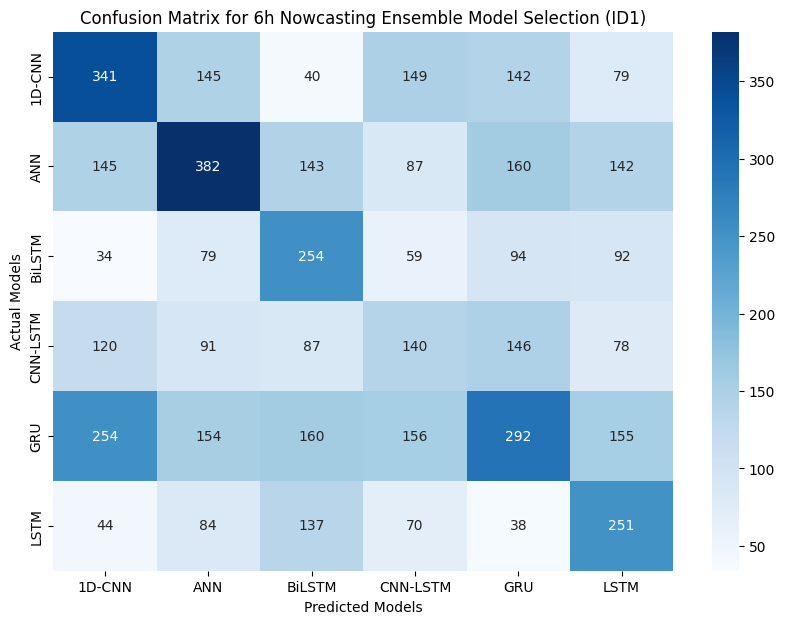

Cohen's Kappa: 0.19333962373748237
McNemar's Test p-value: 1.0 145.0
Chi-Square Test p-value: 7.277621111680064e-261
Matthews Correlation Coefficient: 0.19417756582578116
Jaccard Similarity Index: 0.1967406119979774
              precision    recall  f1-score   support

      1D-CNN       0.36      0.38      0.37       896
         ANN       0.41      0.36      0.38      1059
      BiLSTM       0.31      0.42      0.35       612
    CNN-LSTM       0.21      0.21      0.21       662
         GRU       0.33      0.25      0.29      1171
        LSTM       0.31      0.40      0.35       624

    accuracy                           0.33      5024
   macro avg       0.32      0.34      0.33      5024
weighted avg       0.33      0.33      0.33      5024

Selected
1D-CNN      1192
ANN          875
CNN-LSTM     864
BiLSTM       822
GRU          761
LSTM         510
Name: count, dtype: int64
Selected
BiLSTM      1216
1D-CNN       974
GRU          853
CNN-LSTM     852
ANN          711
LSTM      

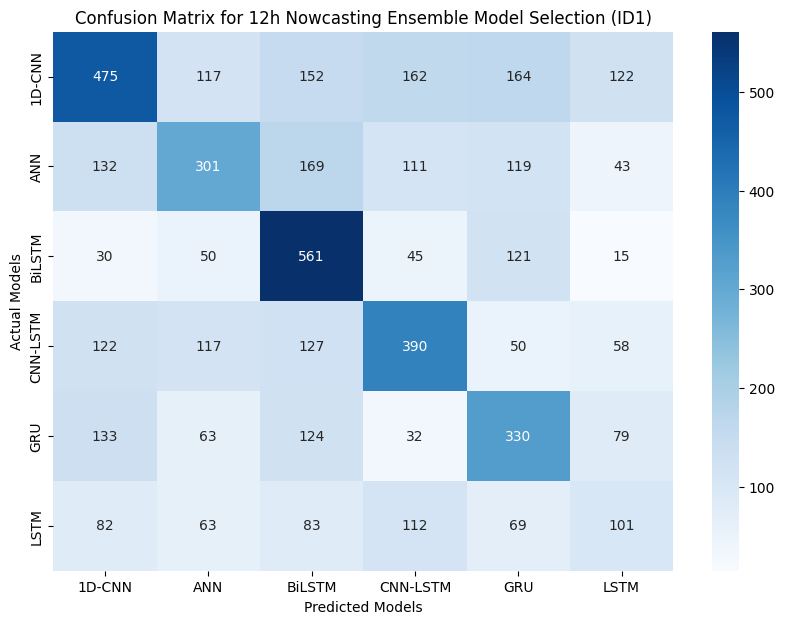

Cohen's Kappa: 0.3097236983717211
McNemar's Test p-value: 0.37499863564655206 117.0
Chi-Square Test p-value: 0.0
Matthews Correlation Coefficient: 0.3115674803524125
Jaccard Similarity Index: 0.26136987600315453
              precision    recall  f1-score   support

      1D-CNN       0.49      0.40      0.44      1192
         ANN       0.42      0.34      0.38       875
      BiLSTM       0.46      0.68      0.55       822
    CNN-LSTM       0.46      0.45      0.45       864
         GRU       0.39      0.43      0.41       761
        LSTM       0.24      0.20      0.22       510

    accuracy                           0.43      5024
   macro avg       0.41      0.42      0.41      5024
weighted avg       0.43      0.43      0.42      5024

Selected
GRU         1374
ANN         1142
1D-CNN       854
CNN-LSTM     594
LSTM         584
BiLSTM       476
Name: count, dtype: int64
Selected
ANN         1019
1D-CNN       973
GRU          894
BiLSTM       844
LSTM         709
CNN-LSTM     5

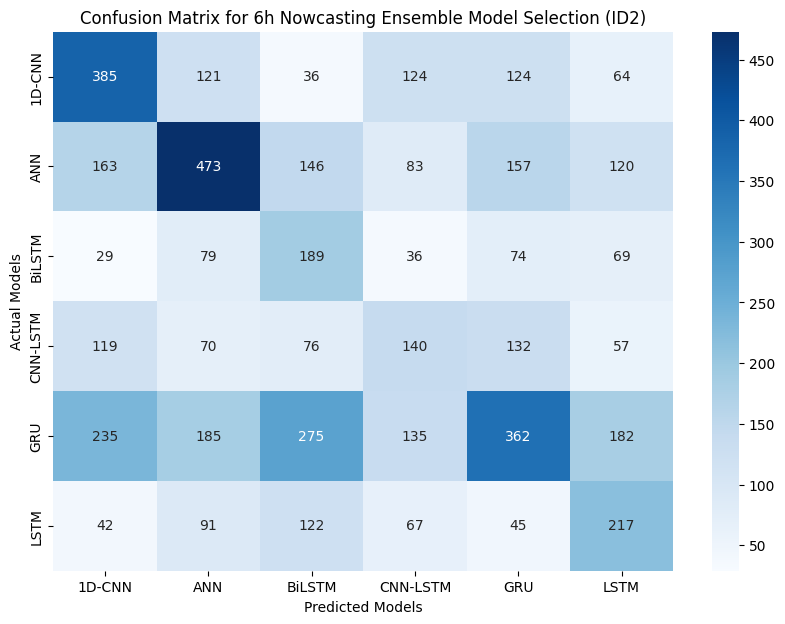

Cohen's Kappa: 0.21511631419722266
McNemar's Test p-value: 0.014832682598133477 121.0
Chi-Square Test p-value: 2.313143573062561e-296
Matthews Correlation Coefficient: 0.21727217981954144
Jaccard Similarity Index: 0.2067761119969915
              precision    recall  f1-score   support

      1D-CNN       0.40      0.45      0.42       854
         ANN       0.46      0.41      0.44      1142
      BiLSTM       0.22      0.40      0.29       476
    CNN-LSTM       0.24      0.24      0.24       594
         GRU       0.40      0.26      0.32      1374
        LSTM       0.31      0.37      0.34       584

    accuracy                           0.35      5024
   macro avg       0.34      0.36      0.34      5024
weighted avg       0.37      0.35      0.35      5024

Selected
1D-CNN      1263
ANN         1025
CNN-LSTM     851
GRU          841
BiLSTM       615
LSTM         429
Name: count, dtype: int64
Selected
1D-CNN      1129
BiLSTM       992
CNN-LSTM     955
GRU          834
ANN       

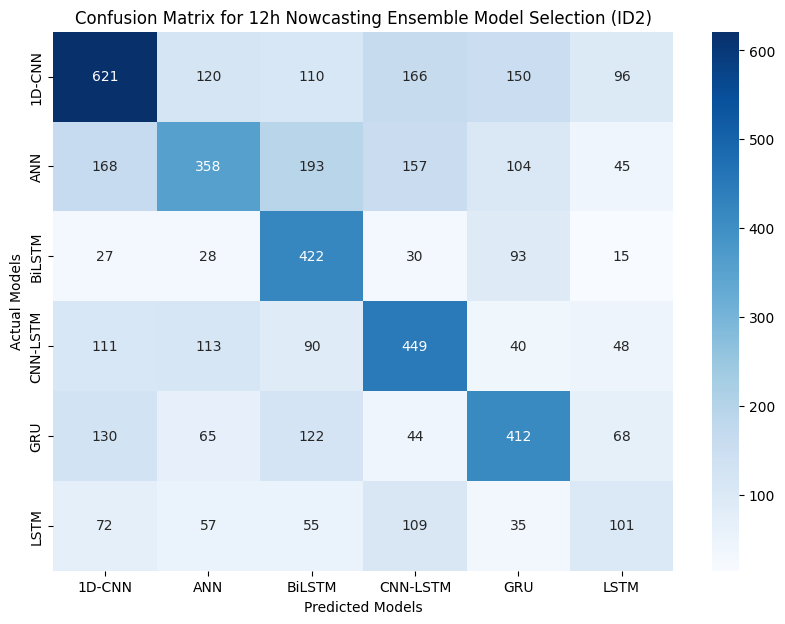

Cohen's Kappa: 0.35636655232736836
McNemar's Test p-value: 0.005521917651043504 120.0
Chi-Square Test p-value: 0.0
Matthews Correlation Coefficient: 0.3585660990368491
Jaccard Similarity Index: 0.29369885343901475
              precision    recall  f1-score   support

      1D-CNN       0.55      0.49      0.52      1263
         ANN       0.48      0.35      0.41      1025
      BiLSTM       0.43      0.69      0.53       615
    CNN-LSTM       0.47      0.53      0.50       851
         GRU       0.49      0.49      0.49       841
        LSTM       0.27      0.24      0.25       429

    accuracy                           0.47      5024
   macro avg       0.45      0.46      0.45      5024
weighted avg       0.47      0.47      0.47      5024

Selected
GRU         1321
ANN         1130
1D-CNN       864
CNN-LSTM     614
LSTM         583
BiLSTM       512
Name: count, dtype: int64
Selected
ANN         993
1D-CNN      958
GRU         888
BiLSTM      828
LSTM        738
CNN-LSTM    619
N

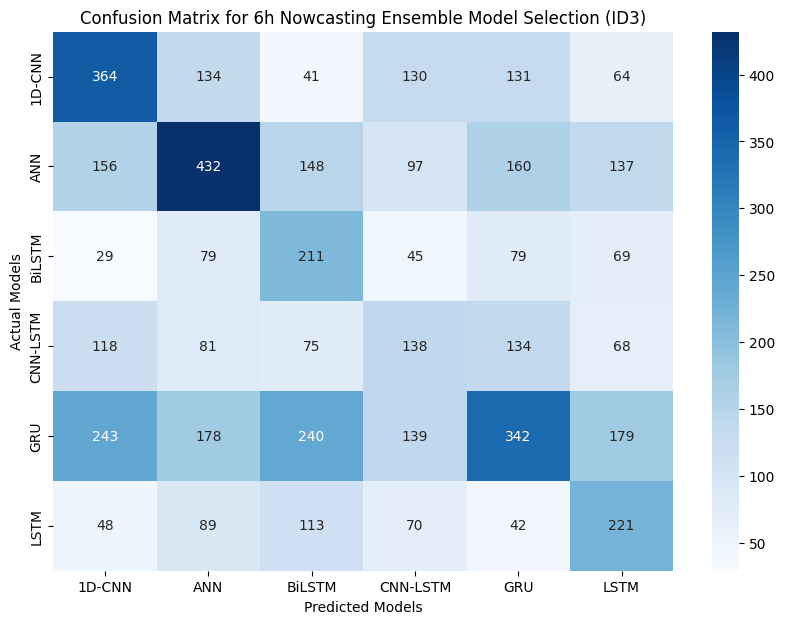

Cohen's Kappa: 0.20225977770935577
McNemar's Test p-value: 0.21744677607656854 134.0
Chi-Square Test p-value: 1.2570596386627542e-262
Matthews Correlation Coefficient: 0.20392643800691135
Jaccard Similarity Index: 0.20035605290072542
              precision    recall  f1-score   support

      1D-CNN       0.38      0.42      0.40       864
         ANN       0.44      0.38      0.41      1130
      BiLSTM       0.25      0.41      0.31       512
    CNN-LSTM       0.22      0.22      0.22       614
         GRU       0.39      0.26      0.31      1321
        LSTM       0.30      0.38      0.33       583

    accuracy                           0.34      5024
   macro avg       0.33      0.35      0.33      5024
weighted avg       0.35      0.34      0.34      5024

Selected
1D-CNN      1244
ANN          981
CNN-LSTM     856
GRU          821
BiLSTM       668
LSTM         454
Name: count, dtype: int64
Selected
1D-CNN      1071
BiLSTM      1061
CNN-LSTM     934
GRU          829
ANN      

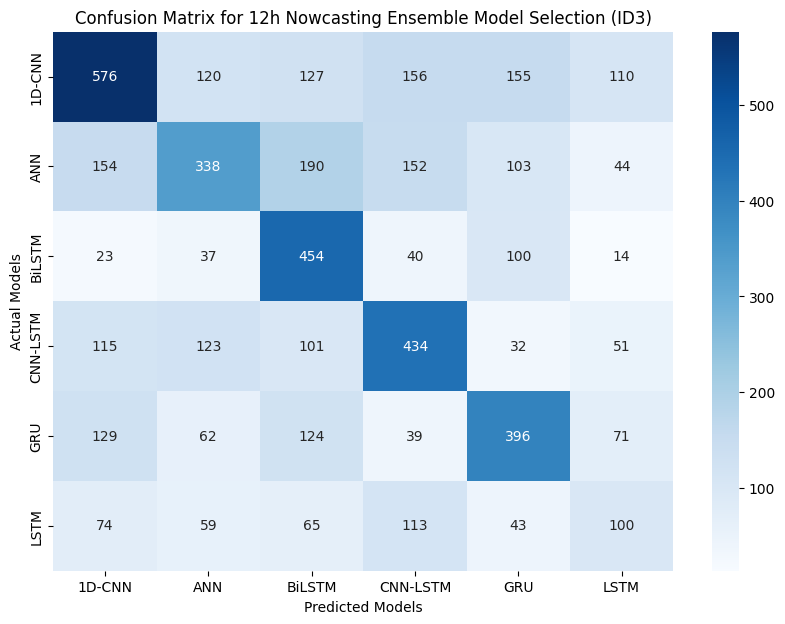

Cohen's Kappa: 0.34211561382483824
McNemar's Test p-value: 0.04599777226248054 120.0
Chi-Square Test p-value: 0.0
Matthews Correlation Coefficient: 0.34420893827898136
Jaccard Similarity Index: 0.28368890476828845
              precision    recall  f1-score   support

      1D-CNN       0.54      0.46      0.50      1244
         ANN       0.46      0.34      0.39       981
      BiLSTM       0.43      0.68      0.53       668
    CNN-LSTM       0.46      0.51      0.48       856
         GRU       0.48      0.48      0.48       821
        LSTM       0.26      0.22      0.24       454

    accuracy                           0.46      5024
   macro avg       0.44      0.45      0.44      5024
weighted avg       0.46      0.46      0.45      5024

Selected
GRU         1483
ANN         1275
1D-CNN       808
LSTM         660
CNN-LSTM     520
BiLSTM       278
Name: count, dtype: int64


FileNotFoundError: [Errno 2] No such file or directory: '../../fusion/partial/forecast6/dsi_ensemble_3_6_ID4_v3_e0.csv'

In [7]:
from sklearn.metrics import (
    cohen_kappa_score,
    confusion_matrix,
    matthews_corrcoef,
    jaccard_score,
    classification_report,
)
from statsmodels.stats.contingency_tables import mcnemar

from scipy.stats import chi2_contingency, fisher_exact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define scenarios
scenarios = {
    1: {"sampling_matrix": np.array([[0, 1]]), "parameters": ["RMSE", "Pearson_r"]},
    2: {
        "sampling_matrix": np.array([[0, 1, 1]]),
        "parameters": ["RMSE", "Pearson_r", "R2"],
    },
    3: {
        "sampling_matrix": np.array([[0, 0, 1]]),
        "parameters": ["RMSE", "MAE", "Pearson_r"],
    },
    4: {"sampling_matrix": np.array([[0, 1]]), "parameters": ["RMSE", "R2"]},
    5: {"sampling_matrix": np.array([[0, 0, 1]]), "parameters": ["RMSE", "MAE", "R2"]},
    6: {
        "sampling_matrix": np.array([[0, 0, 1, 1]]),
        "parameters": ["RMSE", "MAE", "Pearson_r", "R2"],
    },
}

dsi_ensemble = {}

for scenario_id, config in scenarios.items():

    for pred_length in pred_lengths:

        # Complete
        dsi_ensemble_complete = pd.read_csv(
            f"../../fusion/complete/forecast{pred_length}/dsi_ensemble_{pred_length}_{pred_length}_ID{scenario_id}_v{model_id}_e0.csv",
            index_col="Segment",
        )

        selected_complete = dsi_ensemble_complete["Selected"]
        selected_complete_counts = selected_complete.value_counts()
        print(selected_complete_counts)
        # Partial

        dsi_ensemble_partial = pd.read_csv(
            f"../../fusion/partial/forecast{pred_length}/dsi_ensemble_{int(int(pred_length)/2)}_{pred_length}_ID{scenario_id}_v{model_id}_e0.csv",
            index_col="Segment",
        )

        selected_partial = dsi_ensemble_partial["Selected"]

        selected_complete_counts = selected_partial.value_counts()
        print(selected_complete_counts)

        # Confusion Matrix
        # Extract unique model names in the same order from both complete and partial selections
        labels = sorted(list(set(selected_complete) | set(selected_partial)))
        cm = confusion_matrix(selected_complete, selected_partial, labels=labels)
        print("Confusion Matrix:\n", cm)
        # Convert confusion matrix to DataFrame with model names
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        # Print confusion matrix
        print("Confusion Matrix:")
        print(cm_df)

        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_df, annot=True, fmt="g", cmap="Blues")
        plt.title(
            f"Confusion Matrix for {pred_length}h Nowcasting Ensemble Model Selection (ID{scenario_id})"
        )
        plt.xlabel("Predicted Models")
        plt.ylabel("Actual Models")
        plt.show()

        # Cohen's Kappa
        kappa = cohen_kappa_score(selected_complete, selected_partial)
        print(f"Cohen's Kappa: {kappa}")

        # McNemar's Test
        result = mcnemar(cm)
        print(f"McNemar's Test p-value: {result.pvalue} {result.statistic}")

        # Fisher's exact test for 2x2 confusion matrices
        if cm.shape == (2, 2):
            odds_ratio, p_value = fisher_exact(cm)
            print(f"Fisher's Exact Test p-value: {p_value}")

        # Chi-Square Test
        cm = cm.astype(float)
        cm += np.ones(cm.shape) * 1e-6
        chi2, p, dof, ex = chi2_contingency(cm)
        print(f"Chi-Square Test p-value: {p}")

        mcc = matthews_corrcoef(selected_complete, selected_partial)
        print(f"Matthews Correlation Coefficient: {mcc}")

        jaccard = jaccard_score(selected_complete, selected_partial, average="macro")
        print(f"Jaccard Similarity Index: {jaccard}")

        report = classification_report(
            selected_complete, selected_partial, target_names=labels
        )
        print(report)


In [ ]:
# from scipy.stats import pearsonr, spearmanr

# correlation, _ = pearsonr(probabilities_complete, probabilities_partial)
# print(f"Pearson Correlation: {correlation}")


In [ ]:
# # Define the Dempster-Shafer input handler
# ds_handler = DempsterShaferInputHandler(reference_matrix, sampling_matrix)
# ds_handler.normalize_data()
# normalized_reference = ds_handler.get_normalized_reference_matrix()
# normalized_sampling = ds_handler.get_normalized_sampling_matrix()

# normalized_reference_np = normalized_reference.to_numpy()
# normalized_sampling_np = normalized_sampling.to_numpy()
# print(normalized_reference_np)
# print(normalized_sampling_np)

# is_uncertain = "Uncertain" in test_hypotheses
# dsi = DempsterShafer(normalized_reference_np, normalized_sampling_np, is_uncertain)
# dsi.hypothesis_order(test_hypotheses)
# a = dsi.result()
# print(a)


## Initiate DSI

['GRU' '1D-CNN' 'ANN']
GRU


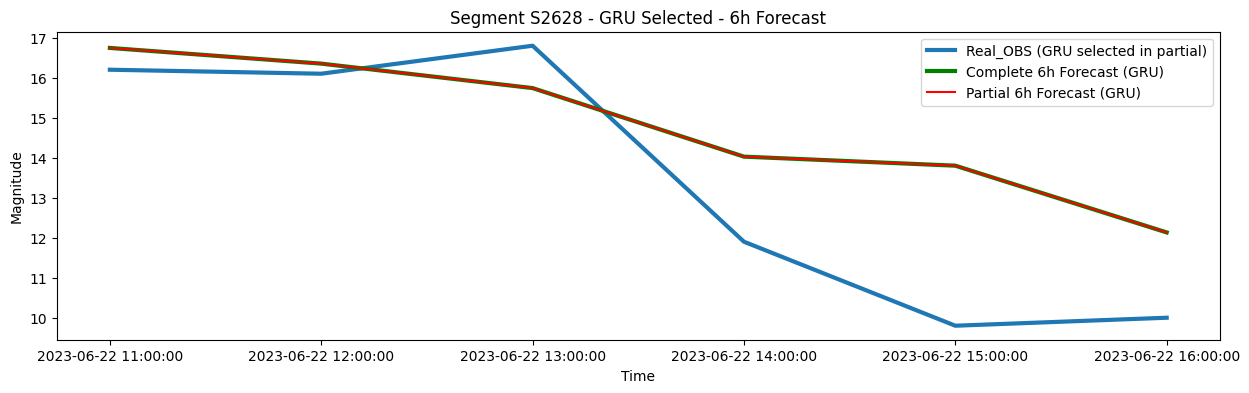

GRU


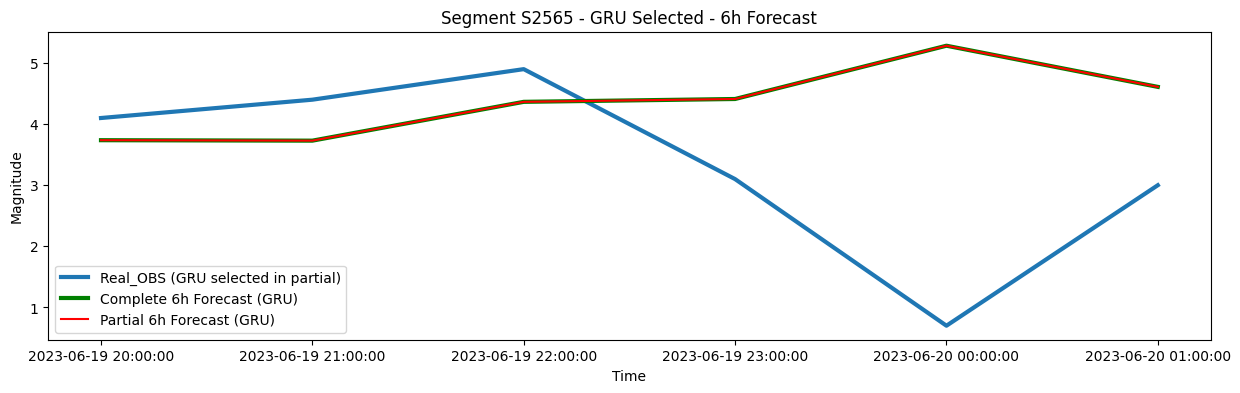

GRU


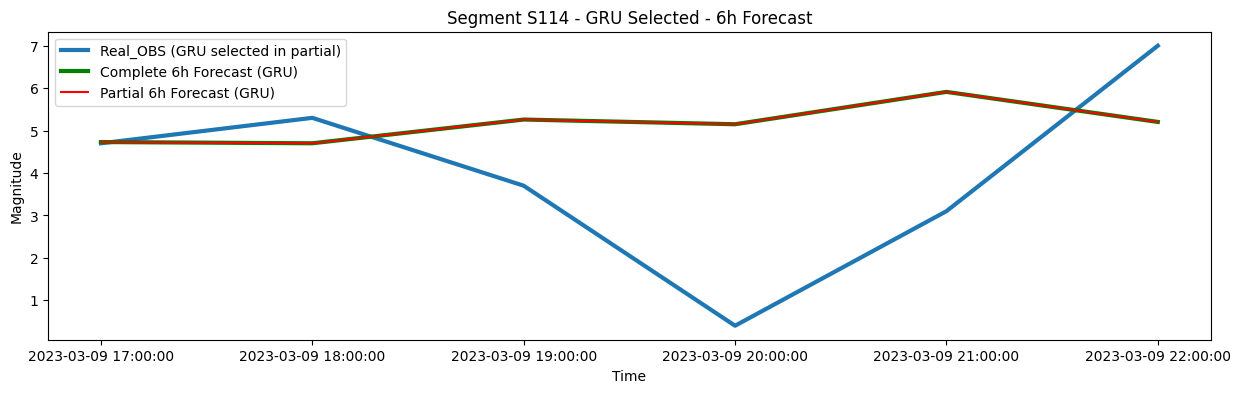

GRU


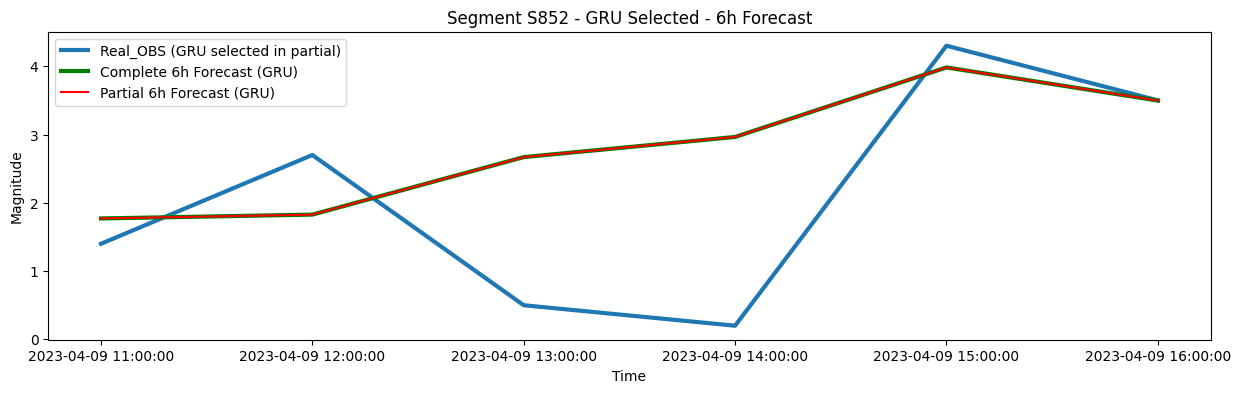

1D-CNN


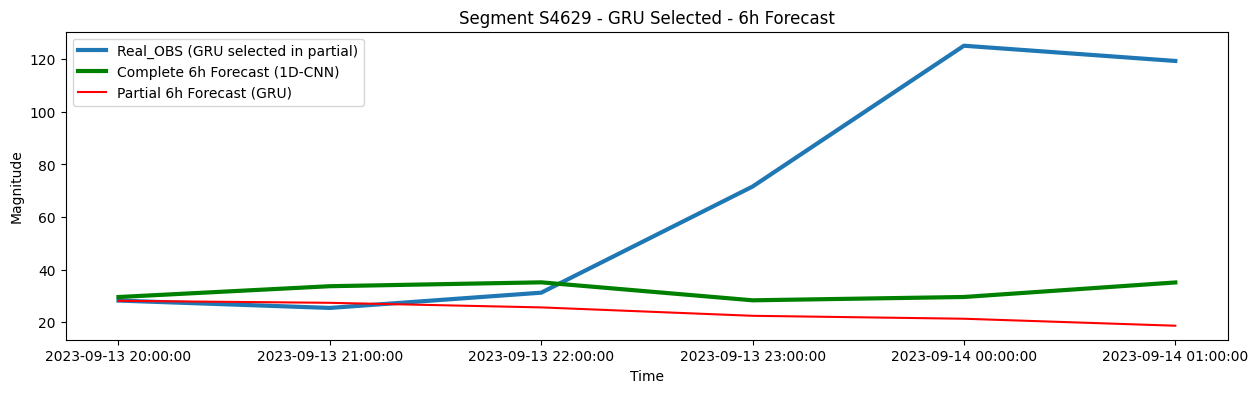

GRU


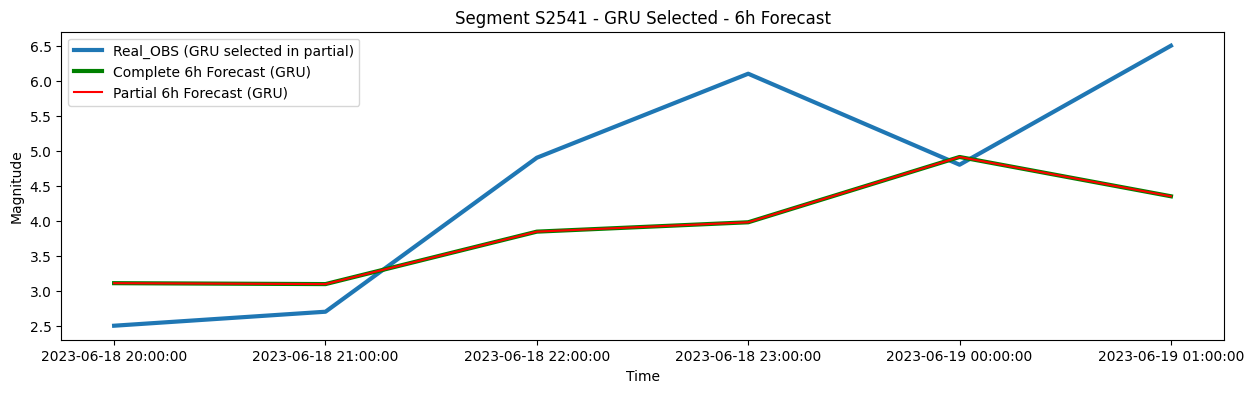

GRU


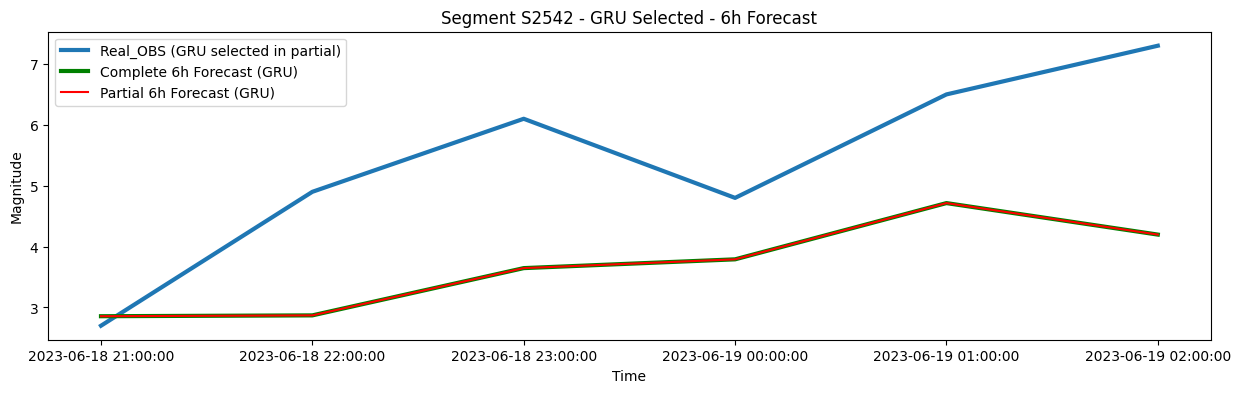

GRU


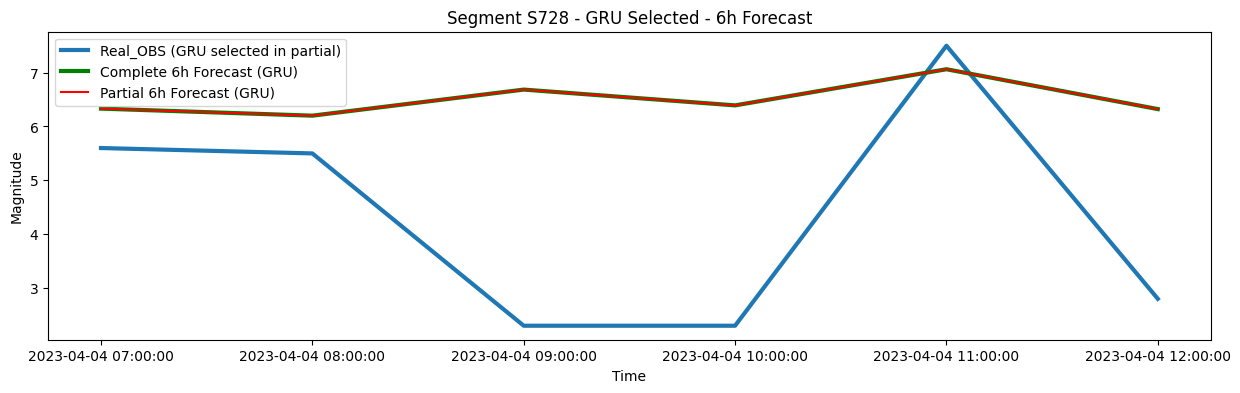

1D-CNN


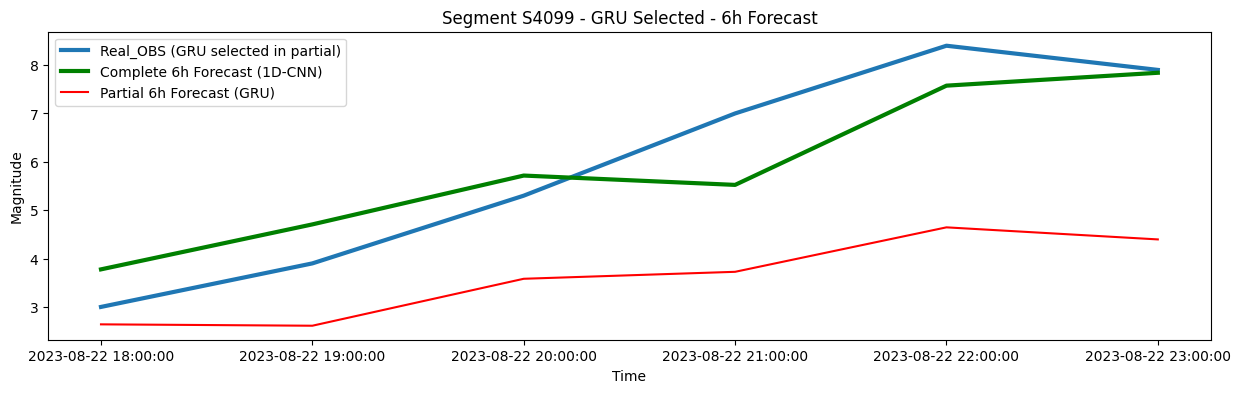

GRU


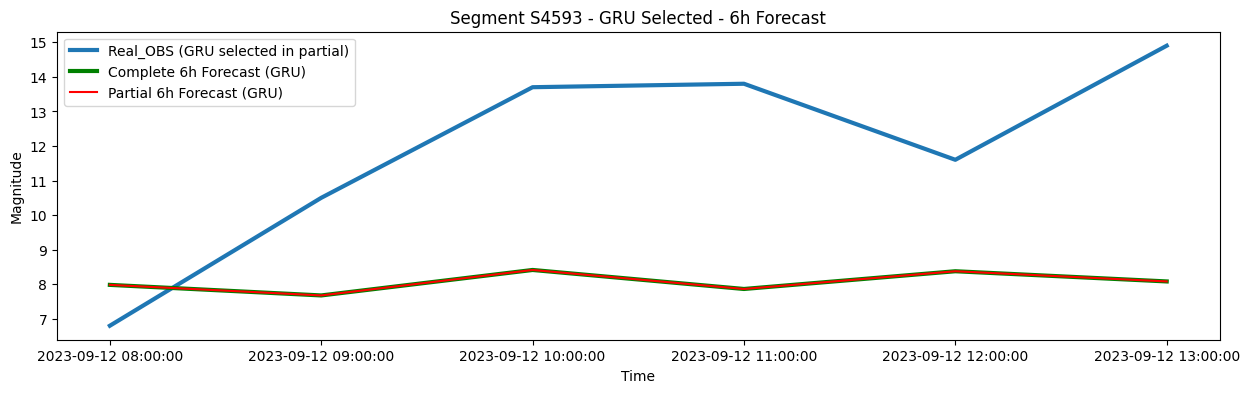

1D-CNN


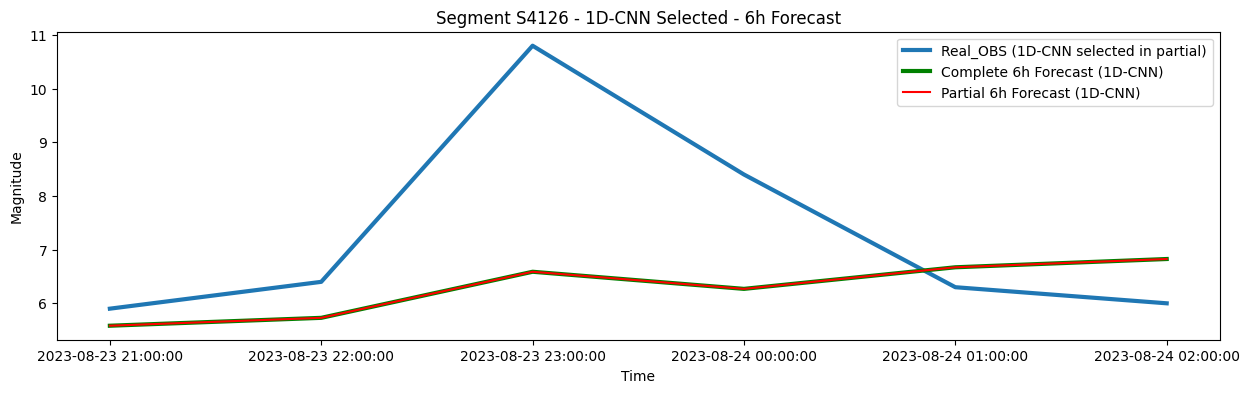

1D-CNN


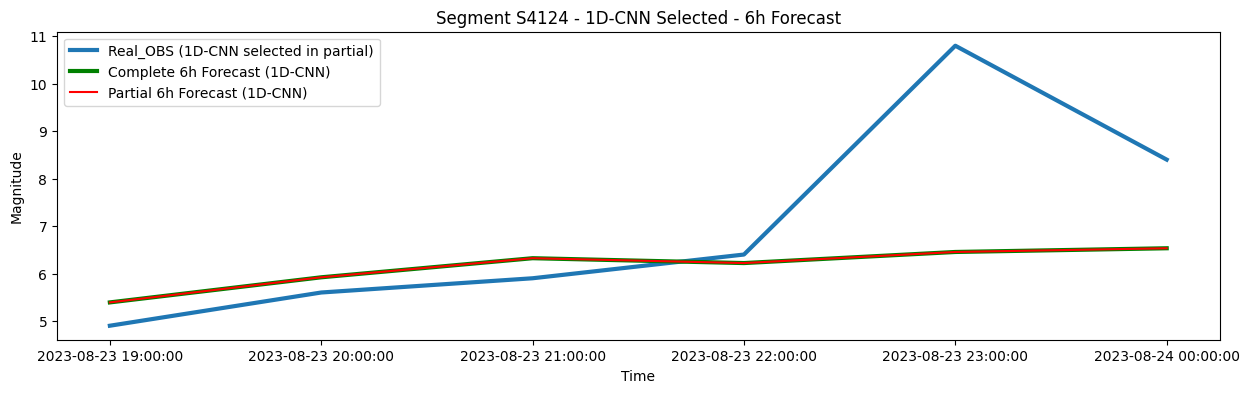

1D-CNN


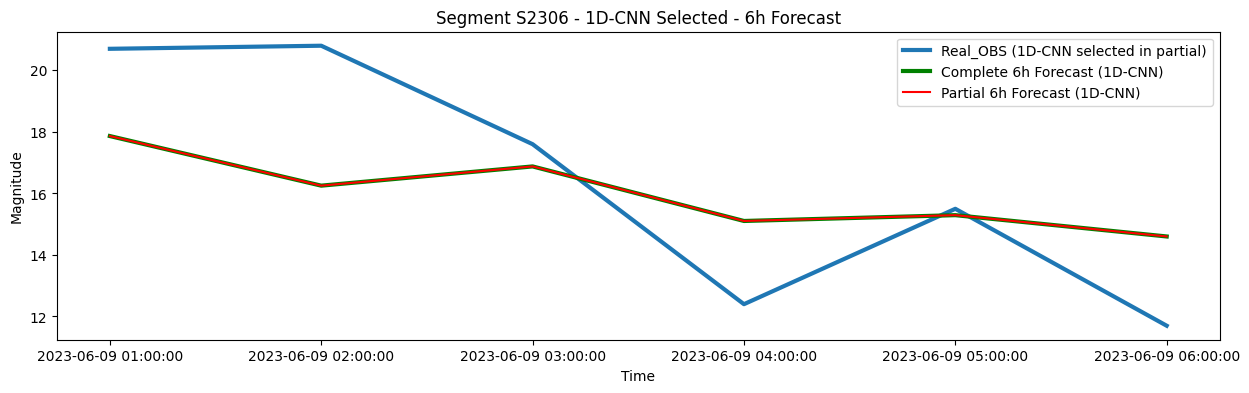

1D-CNN


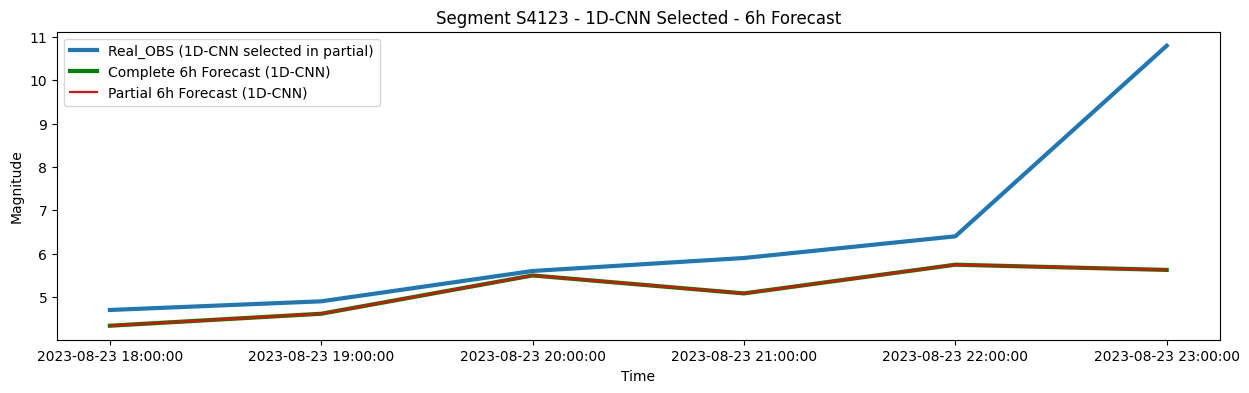

1D-CNN


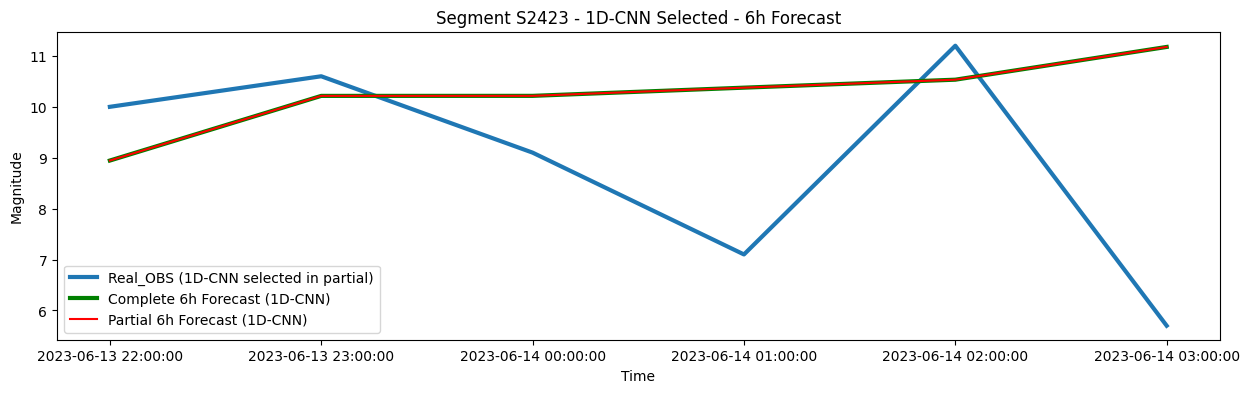

1D-CNN


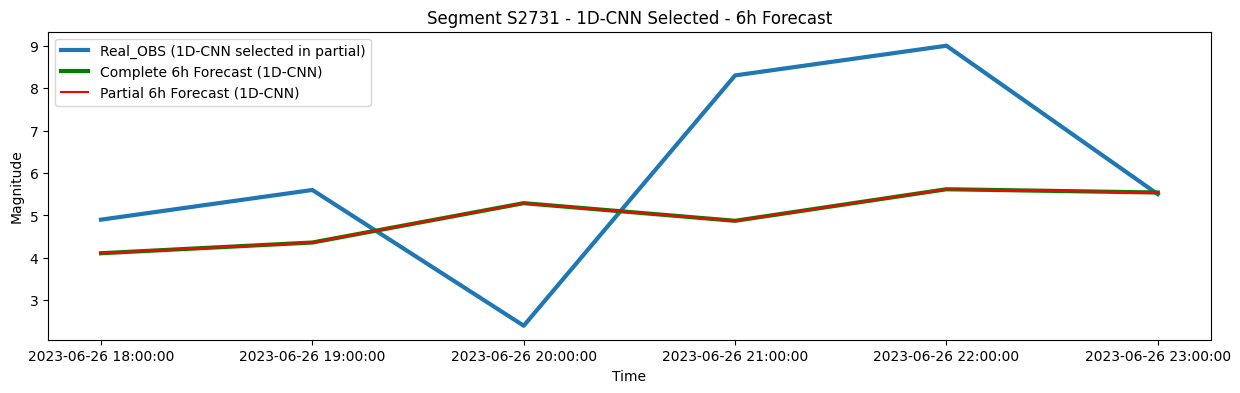

1D-CNN


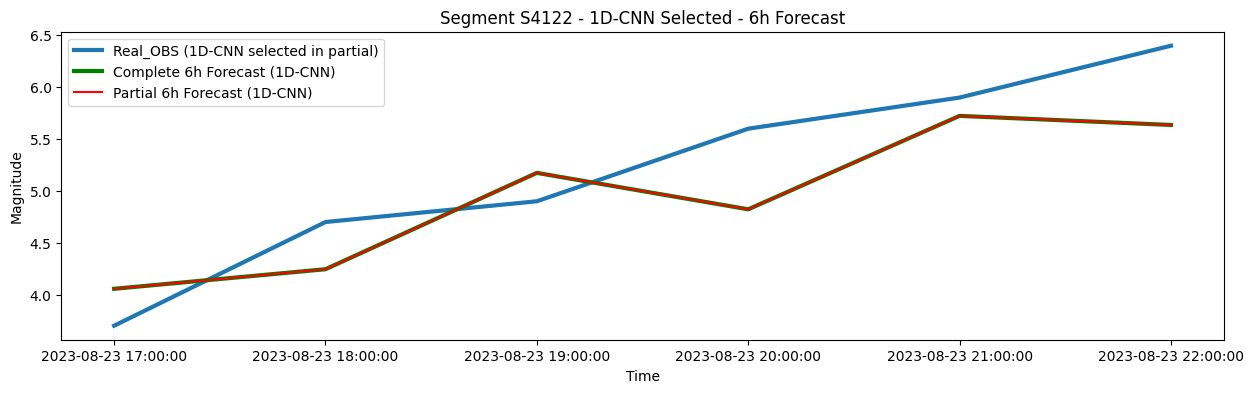

ANN


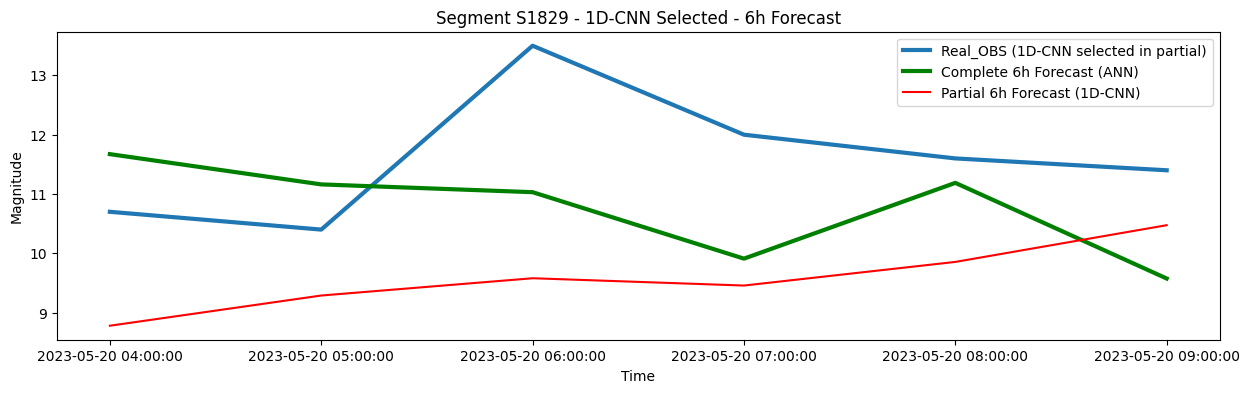

1D-CNN


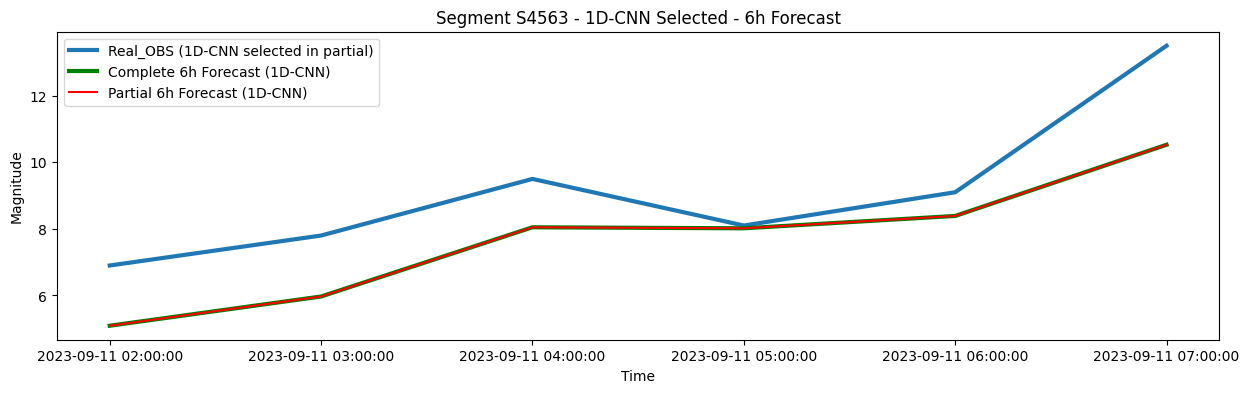

1D-CNN


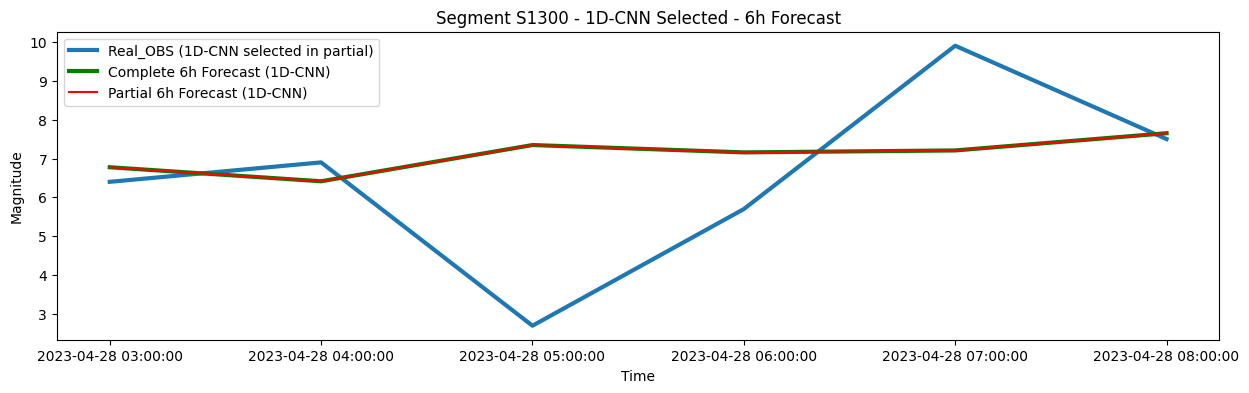

ANN


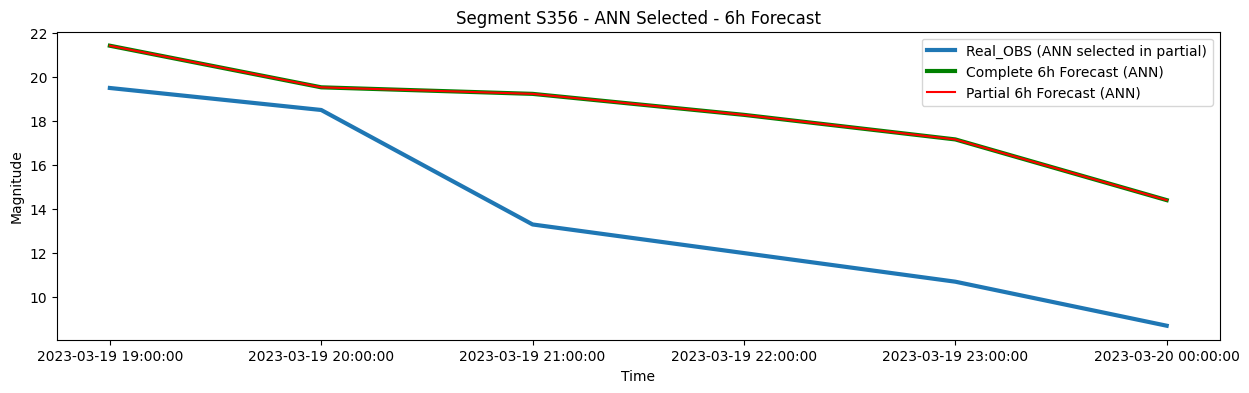

GRU


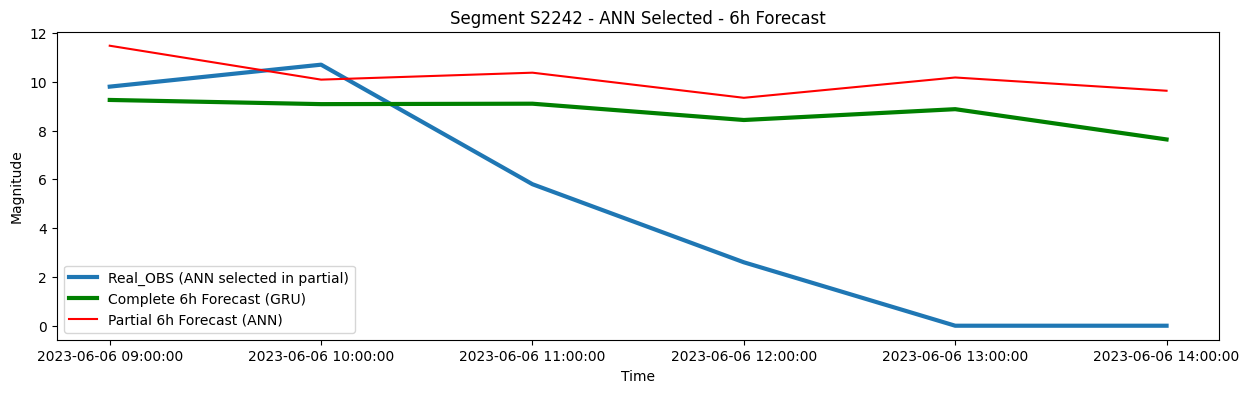

ANN


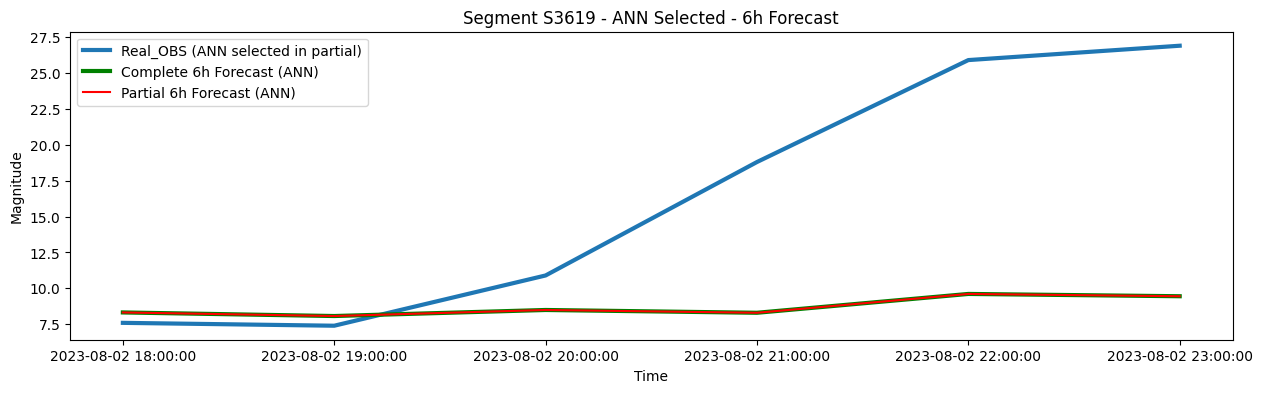

ANN


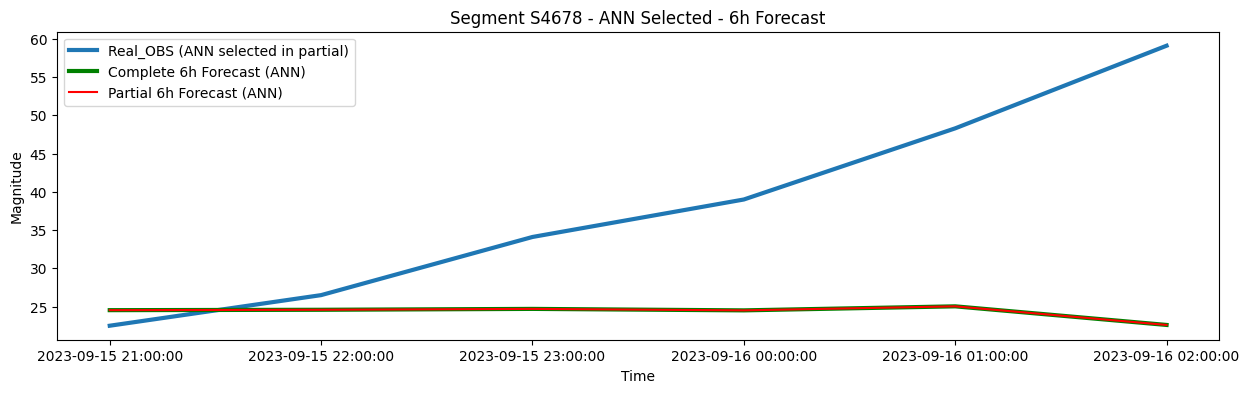

GRU


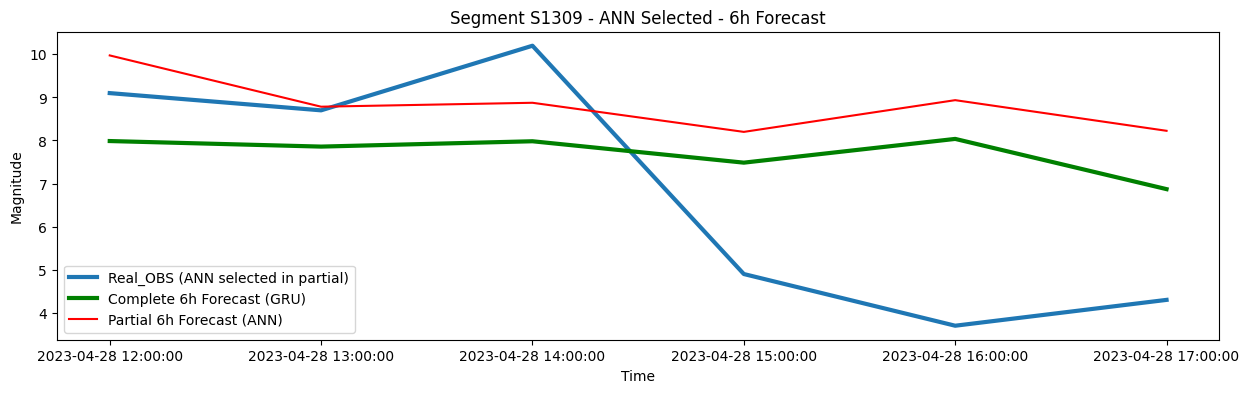

ANN


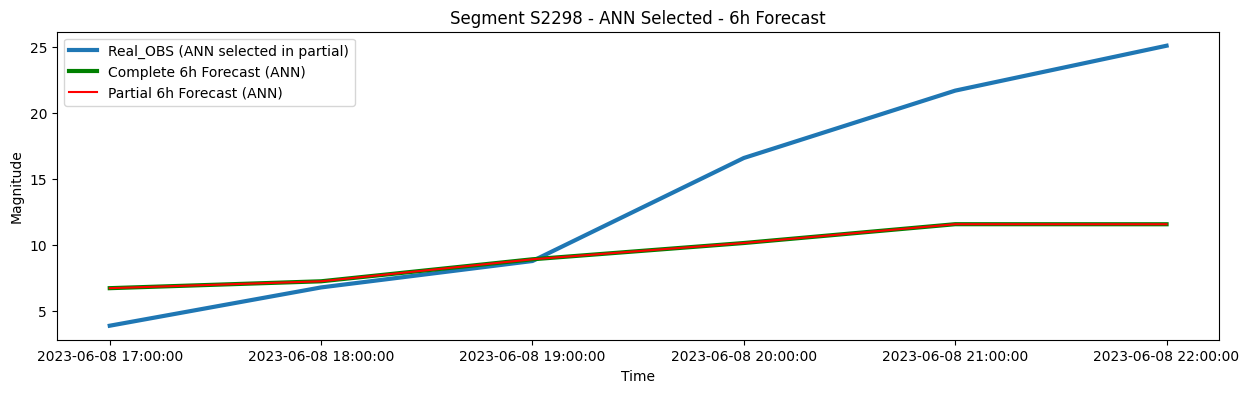

ANN


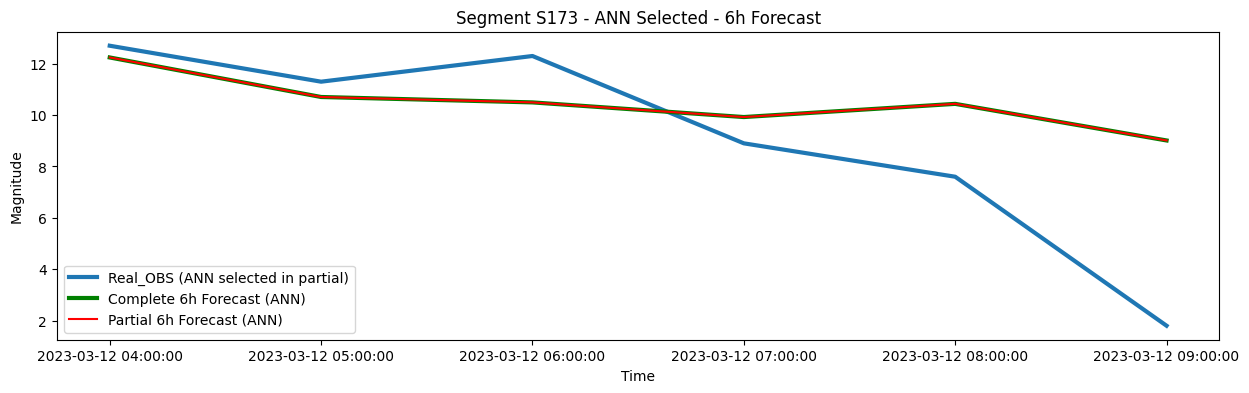

ANN


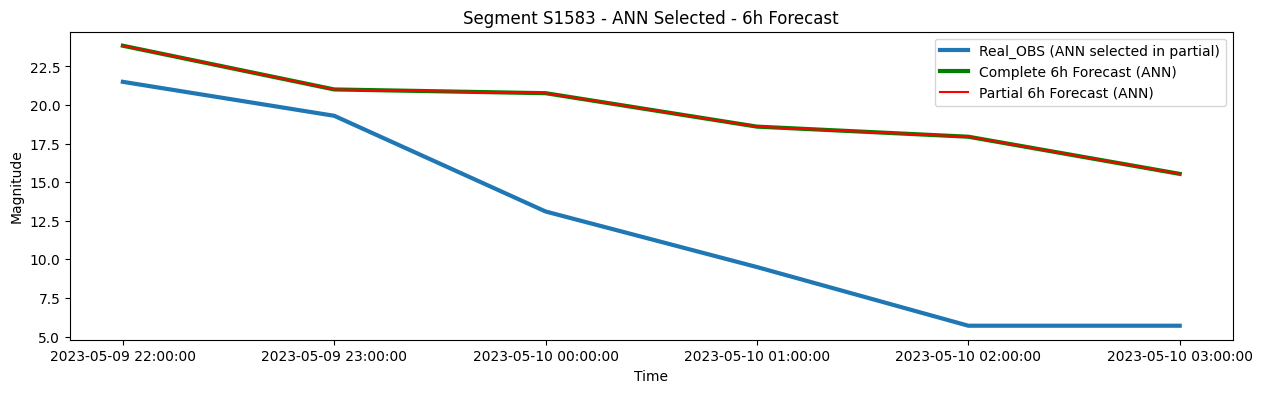

ANN


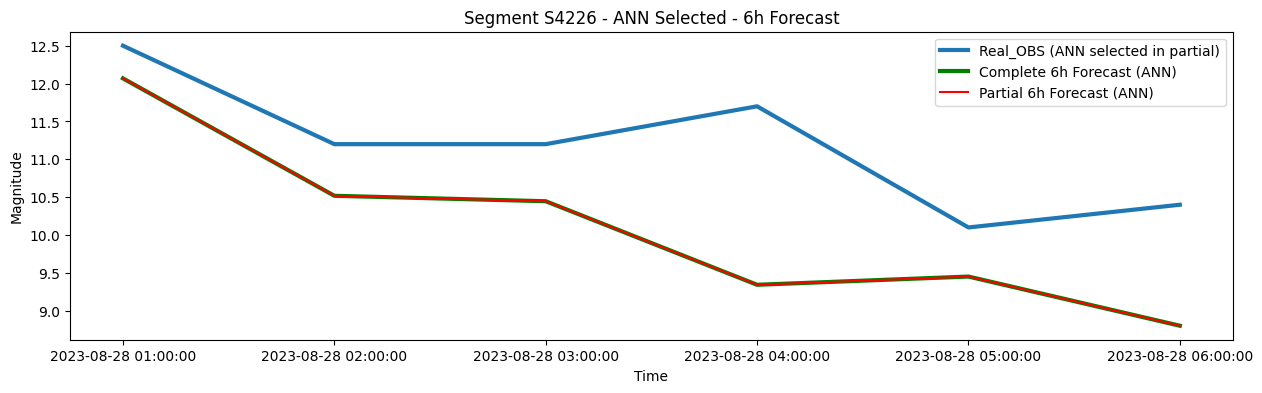

GRU


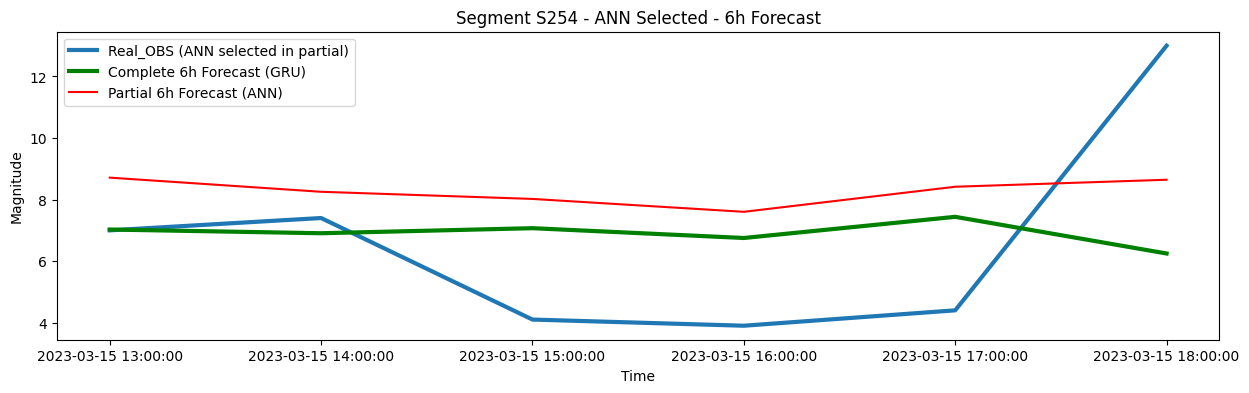

['GRU' '1D-CNN' 'ANN']
GRU


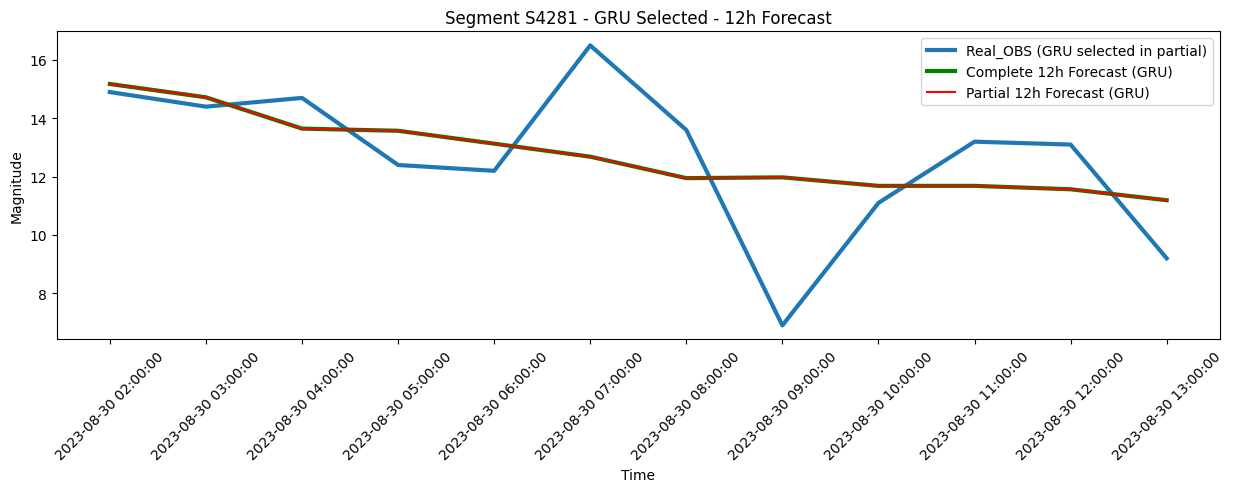

GRU


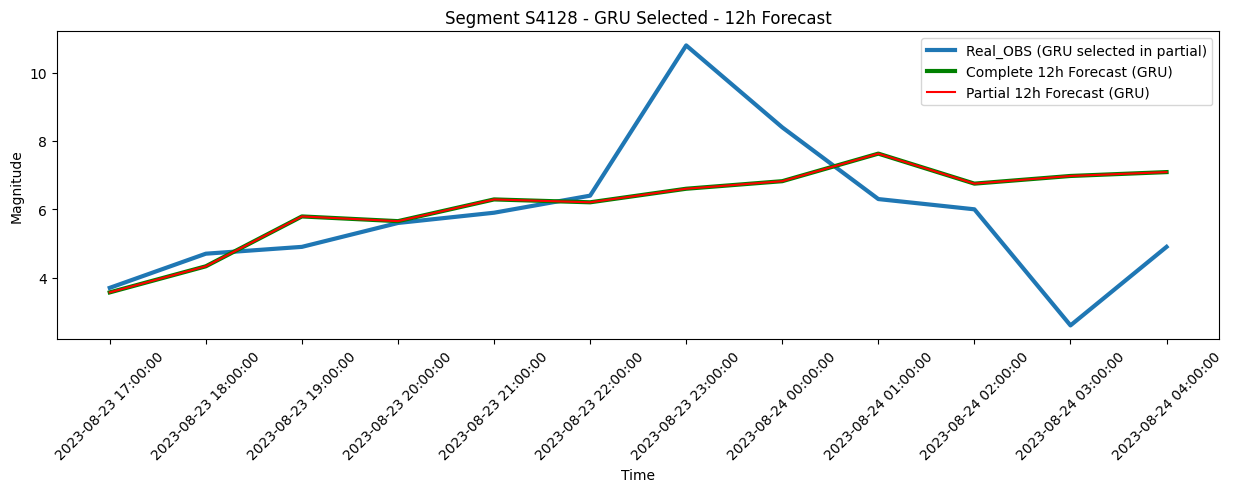

GRU


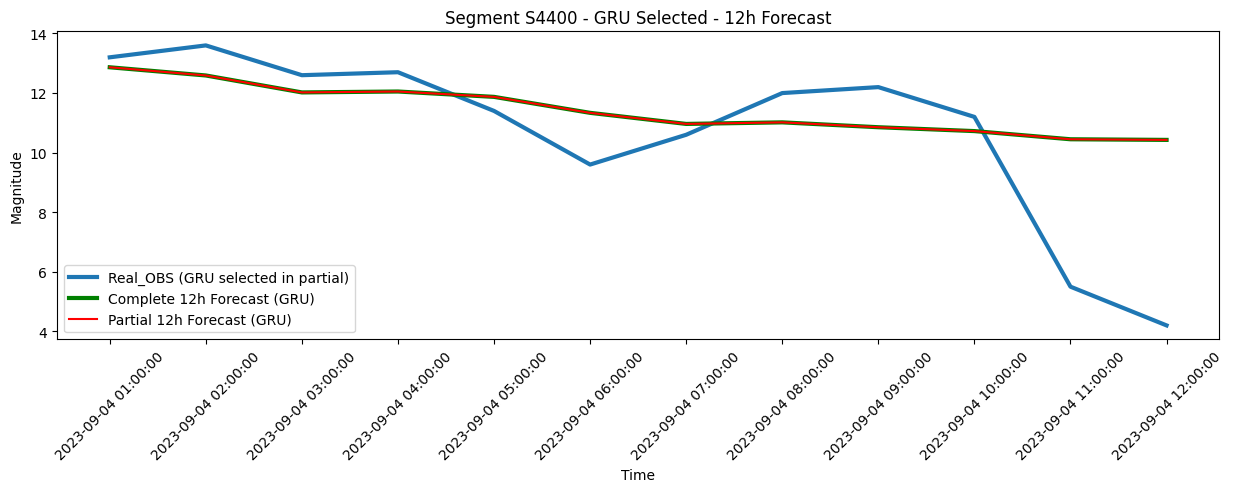

ANN


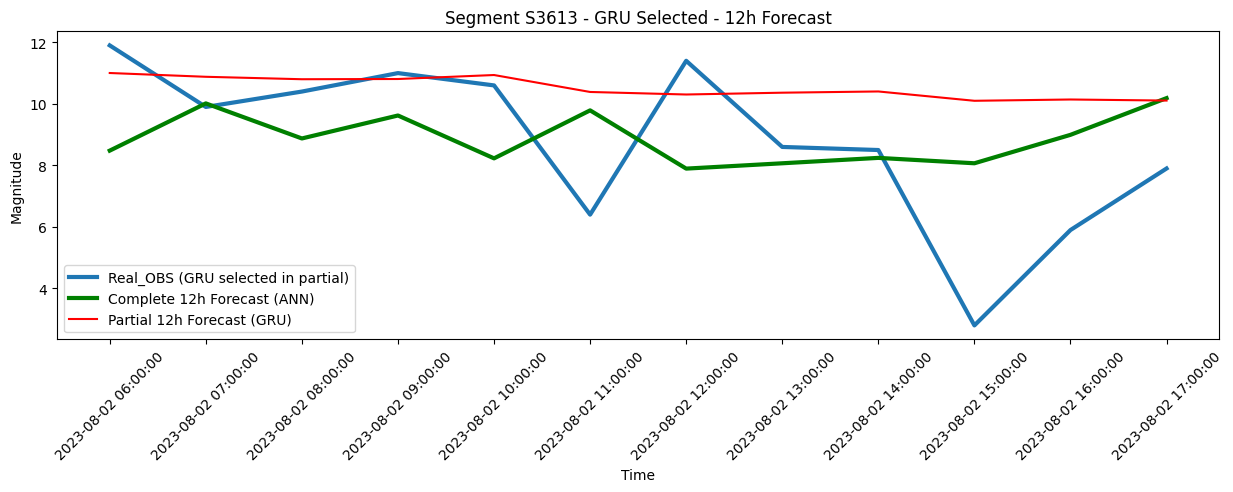

ANN


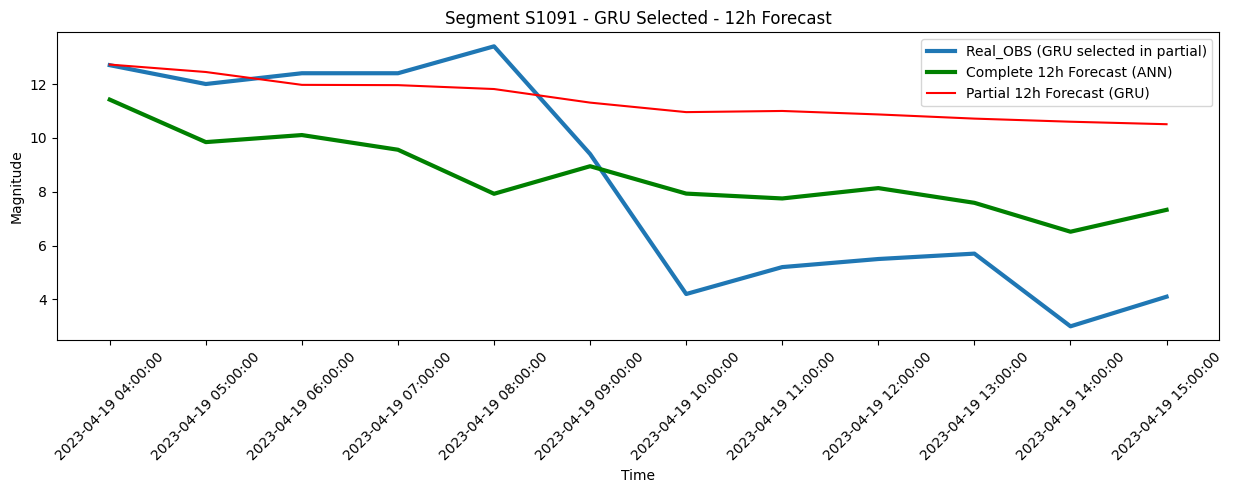

ANN


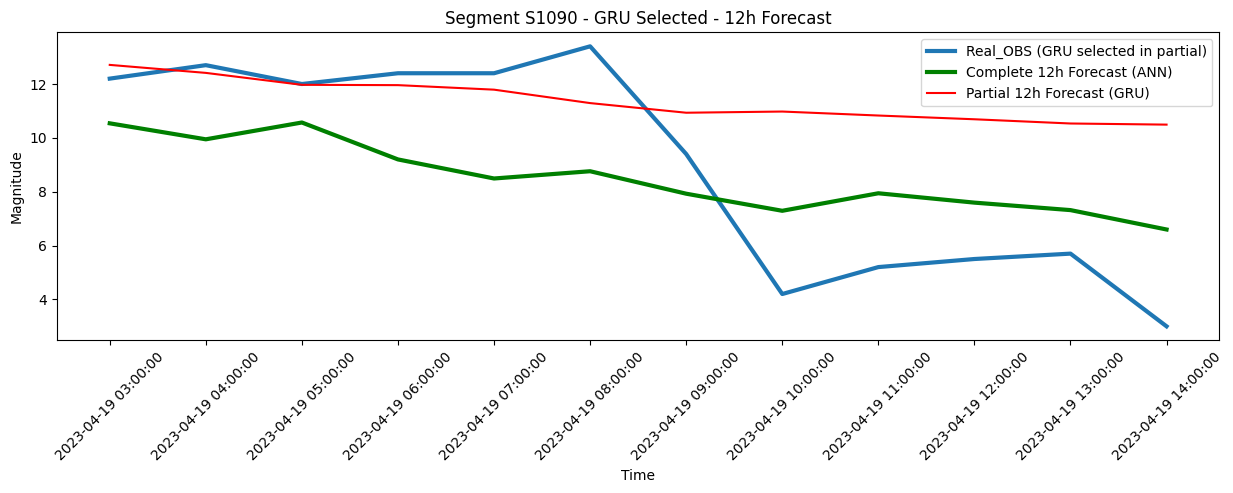

GRU


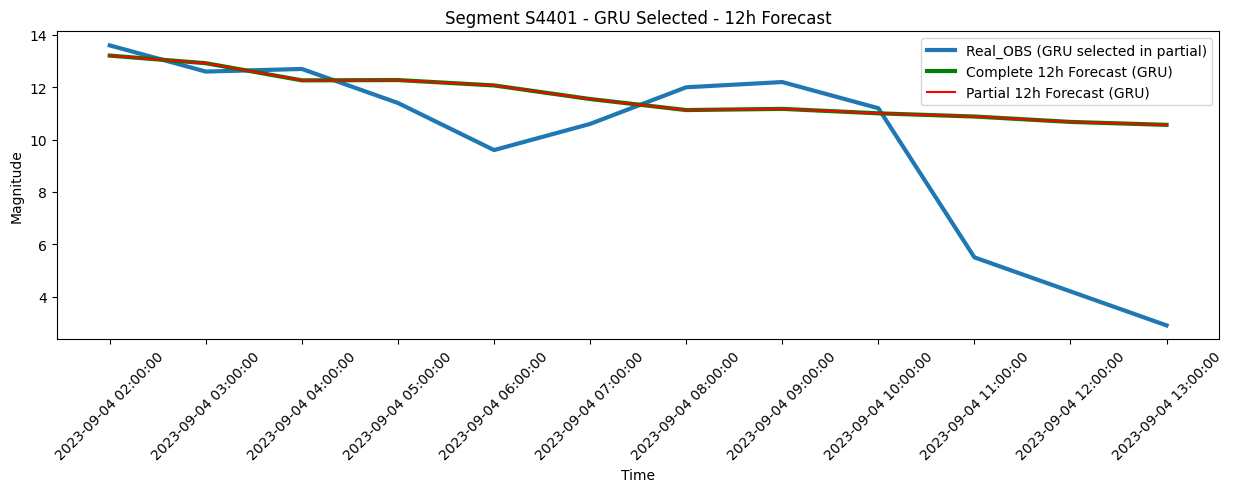

GRU


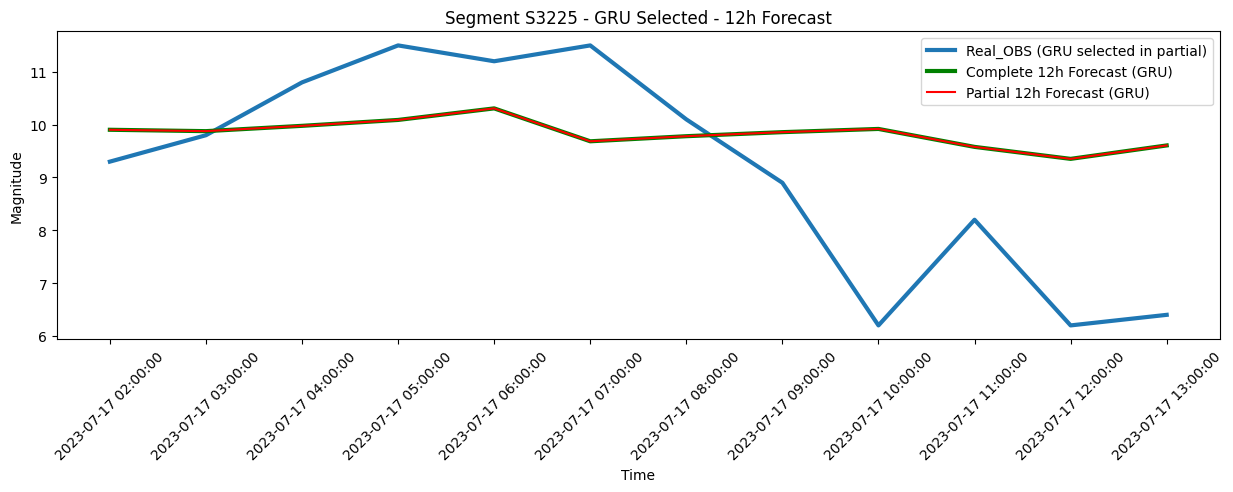

ANN


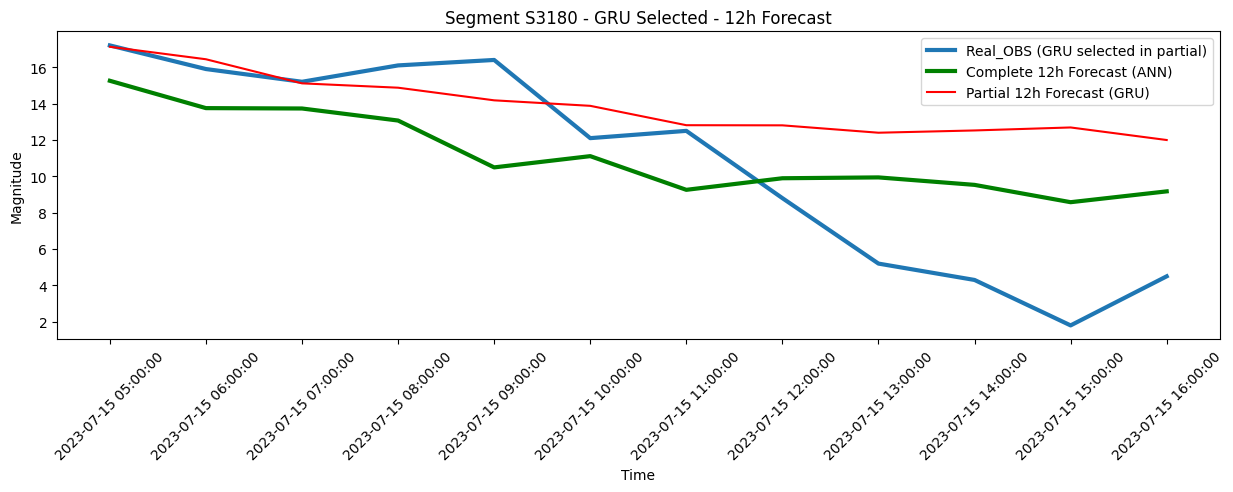

GRU


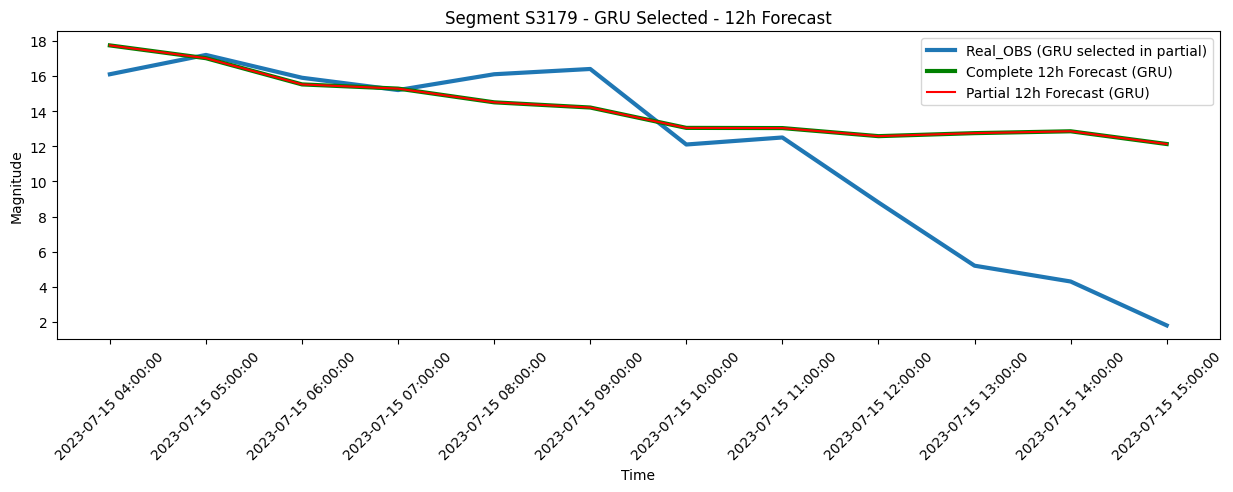

1D-CNN


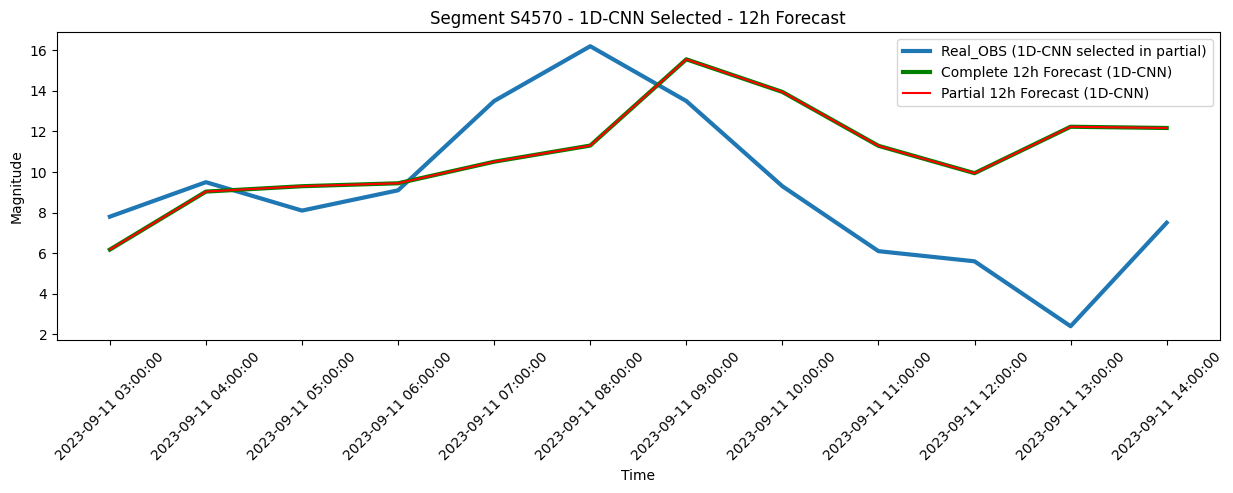

1D-CNN


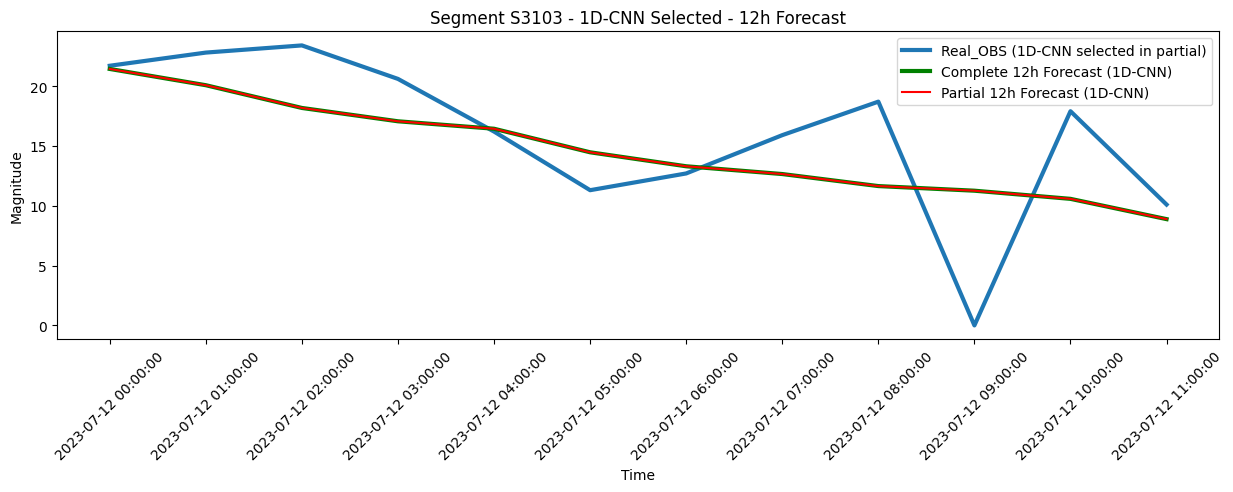

1D-CNN


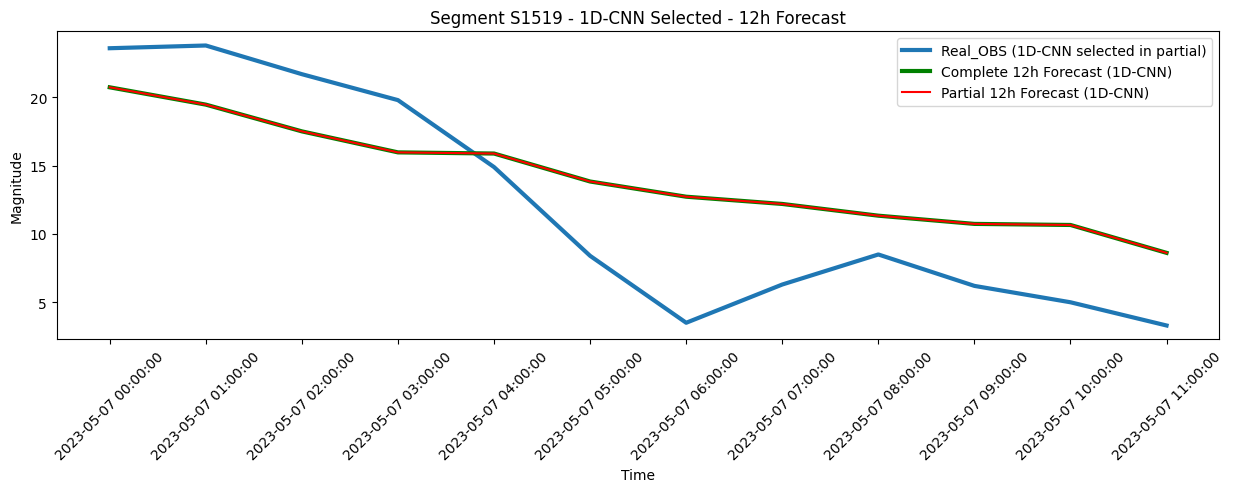

1D-CNN


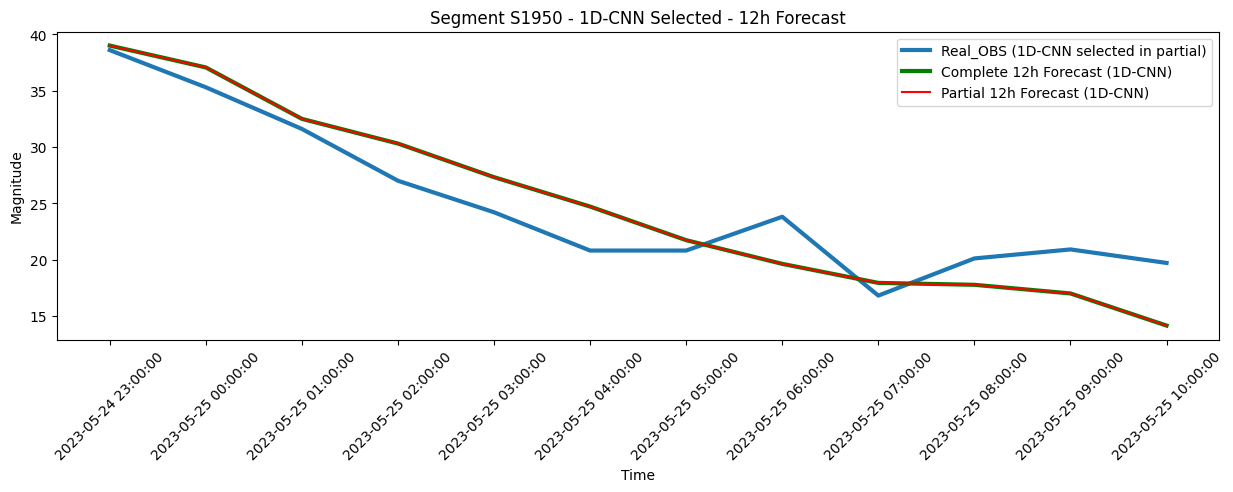

1D-CNN


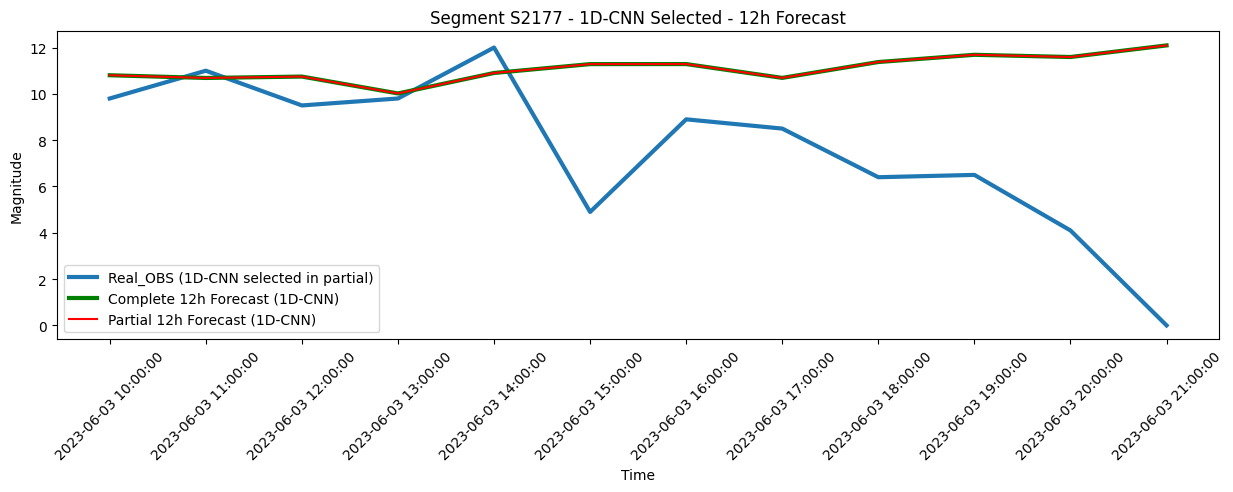

1D-CNN


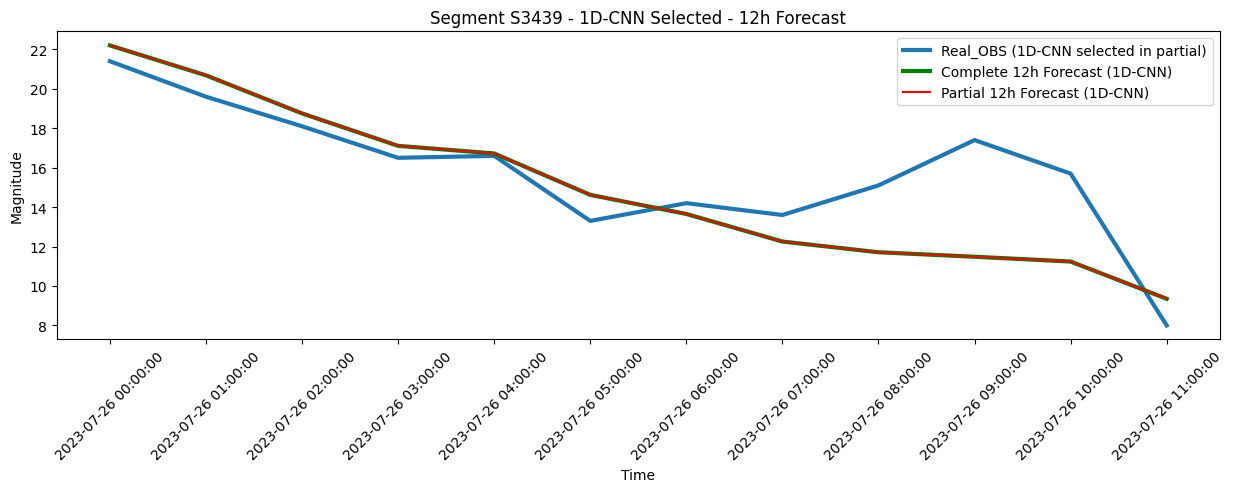

1D-CNN


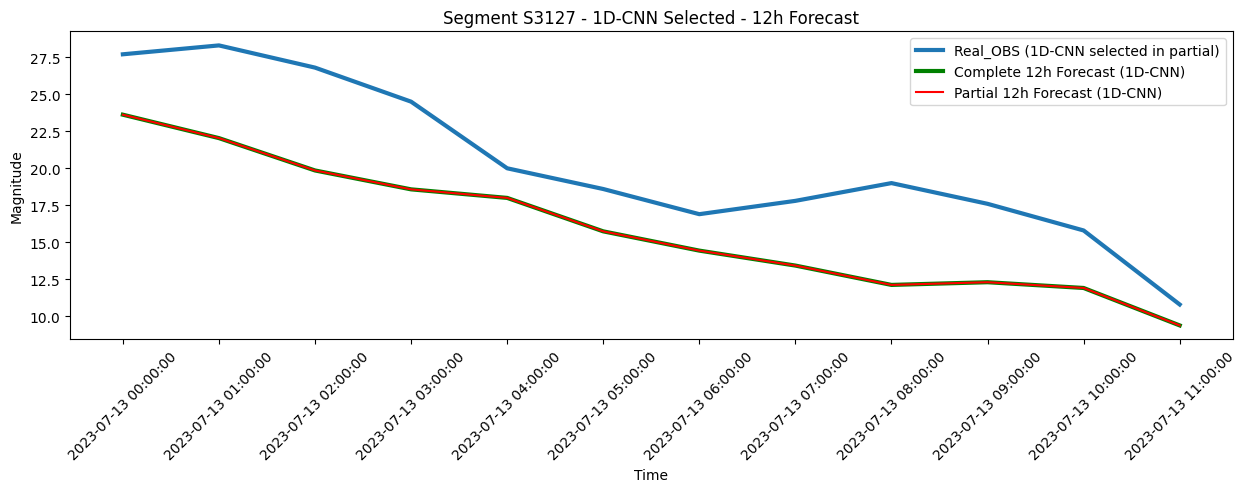

1D-CNN


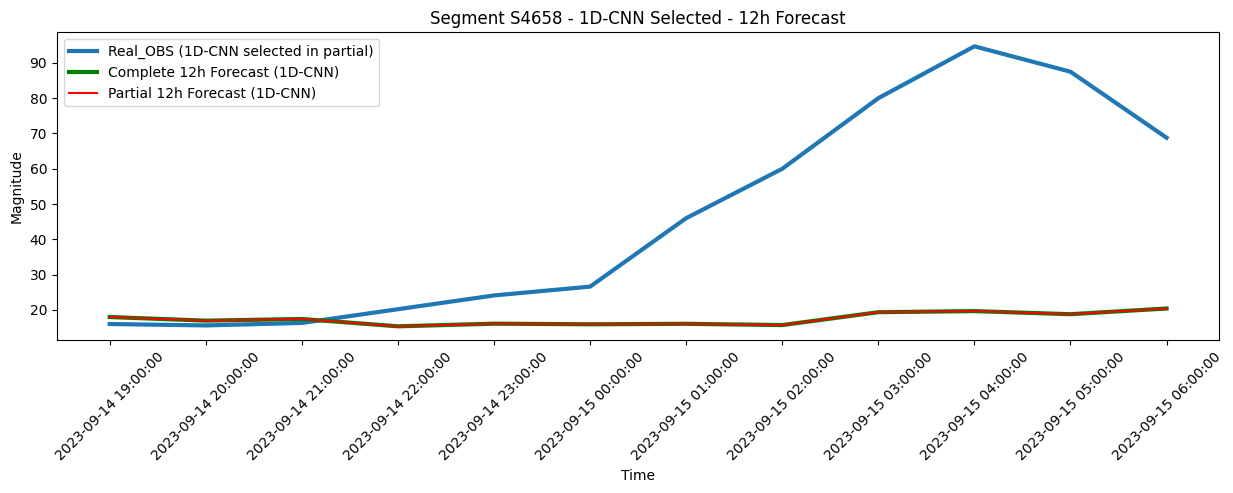

1D-CNN


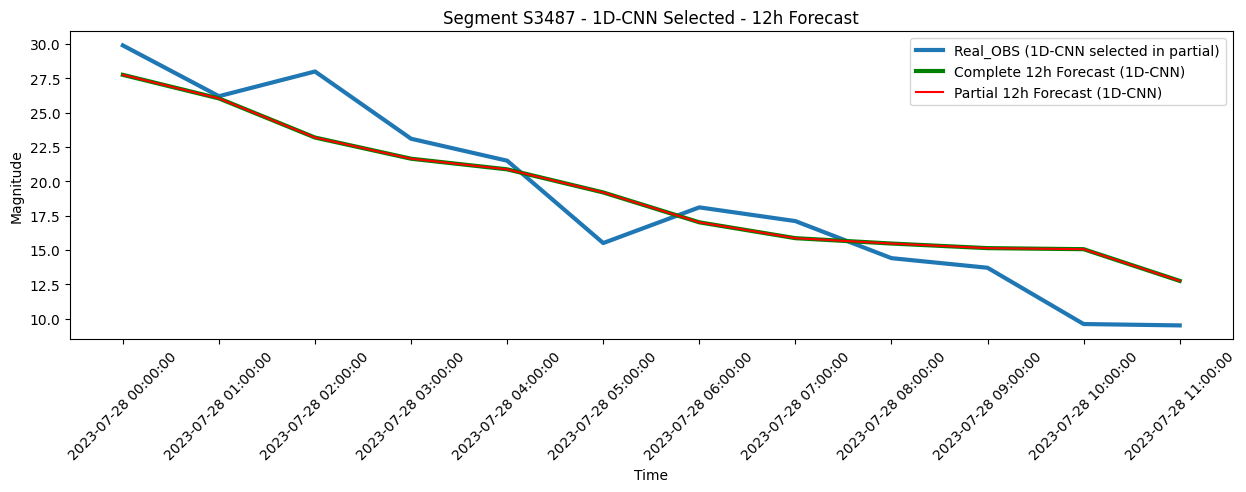

ANN


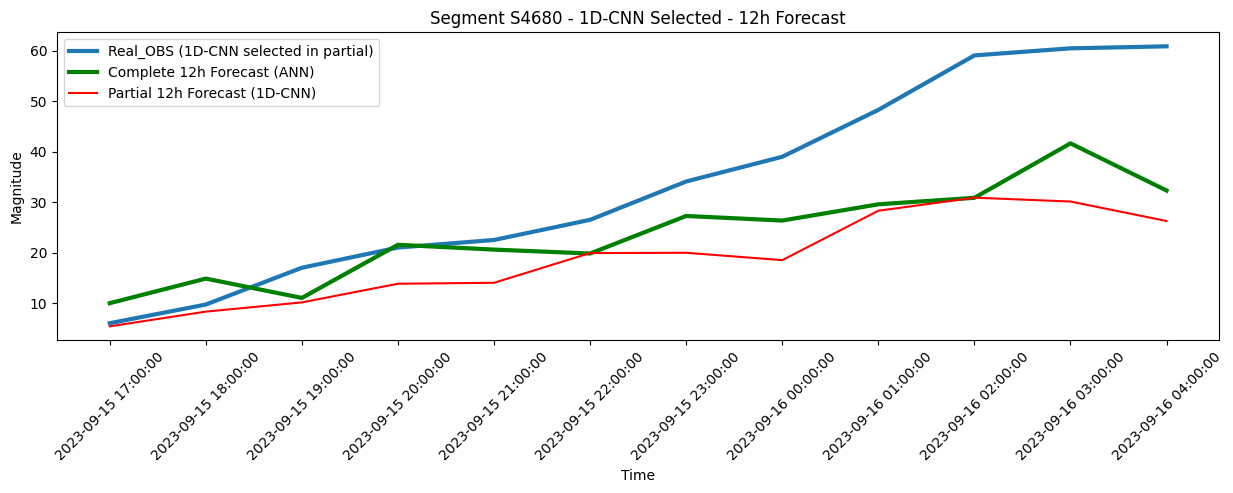

ANN


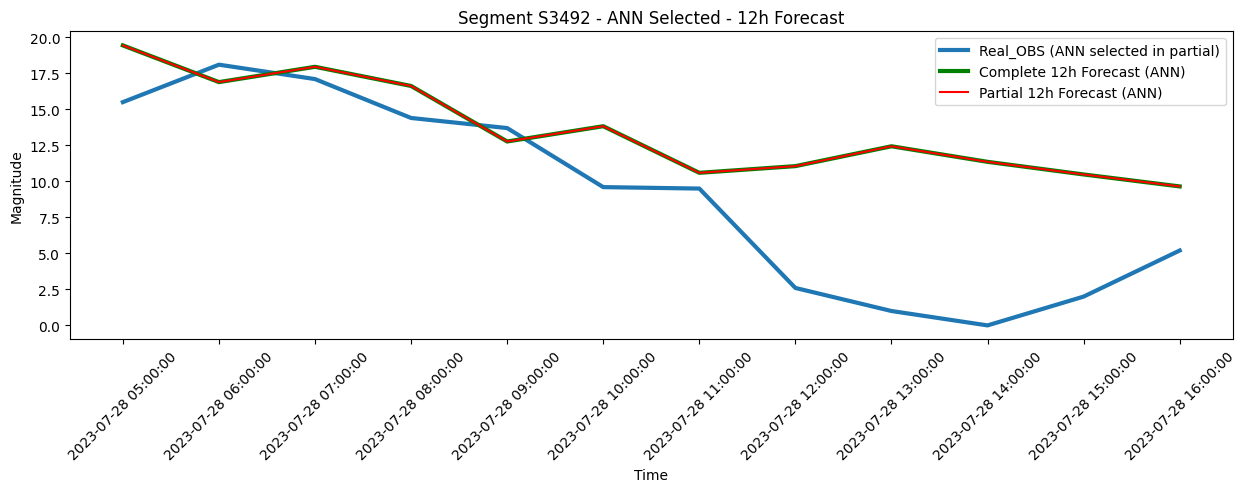

ANN


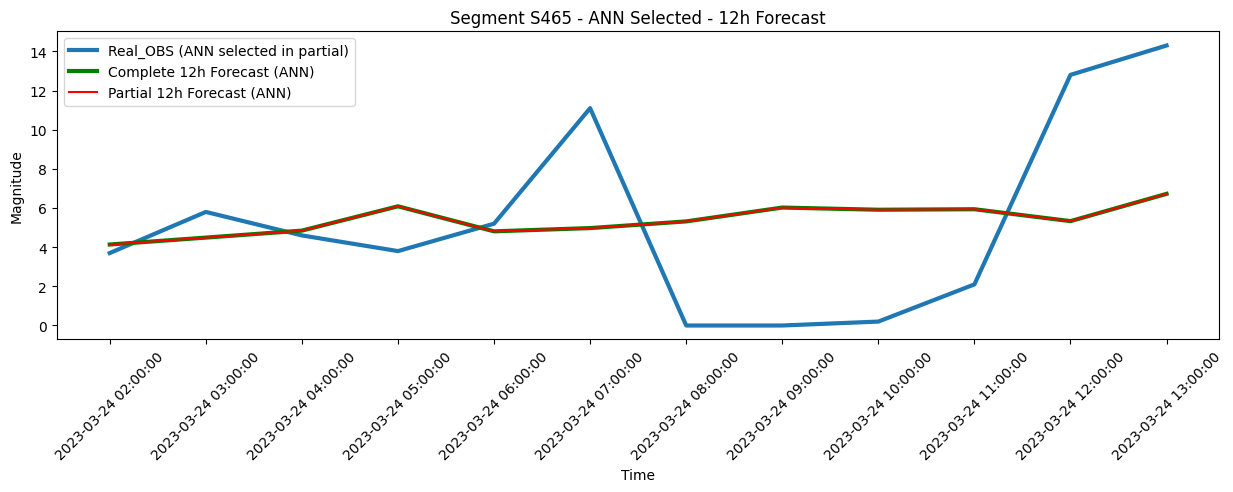

ANN


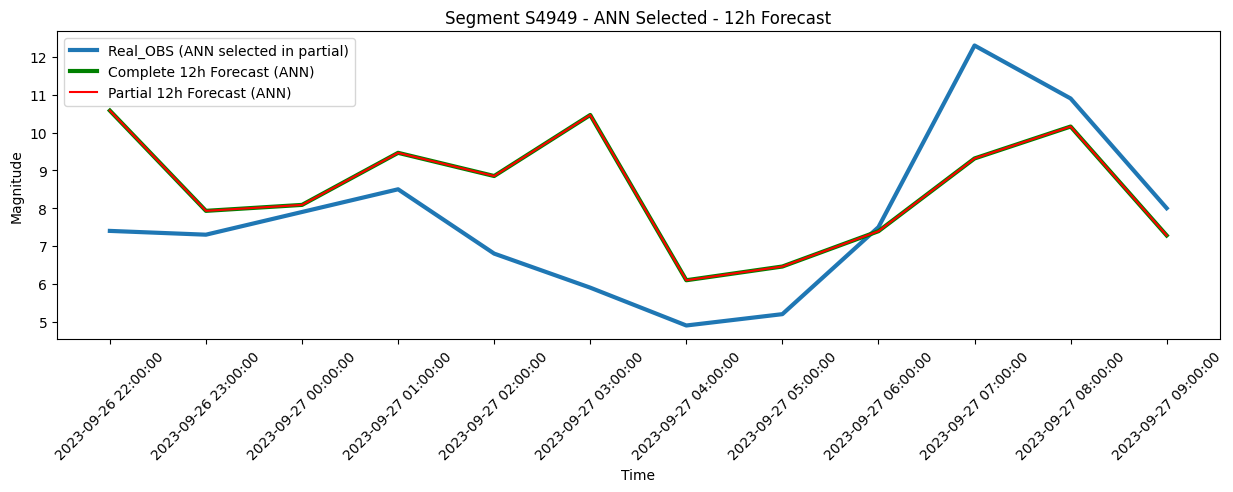

ANN


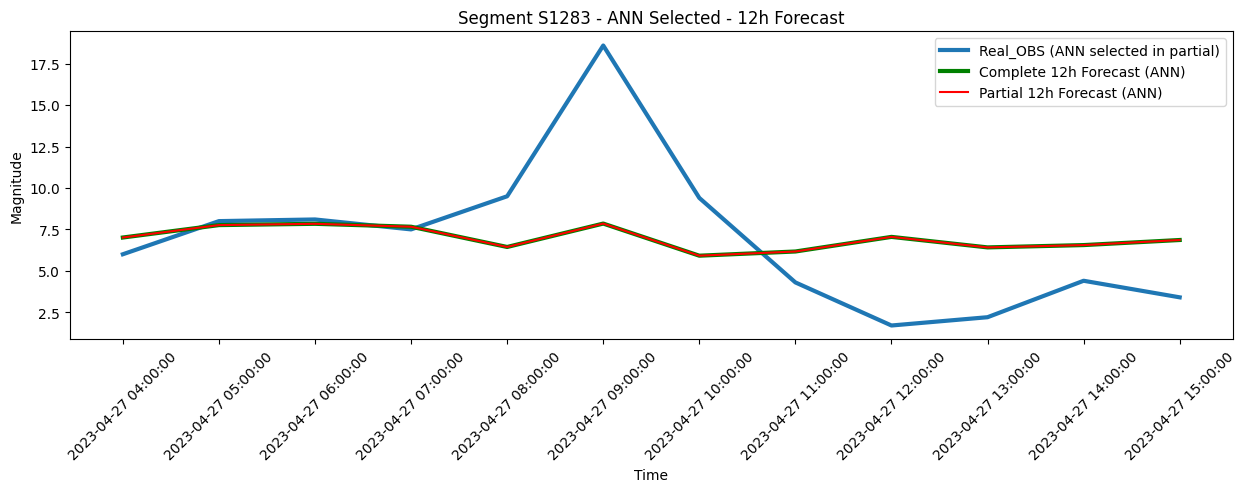

ANN


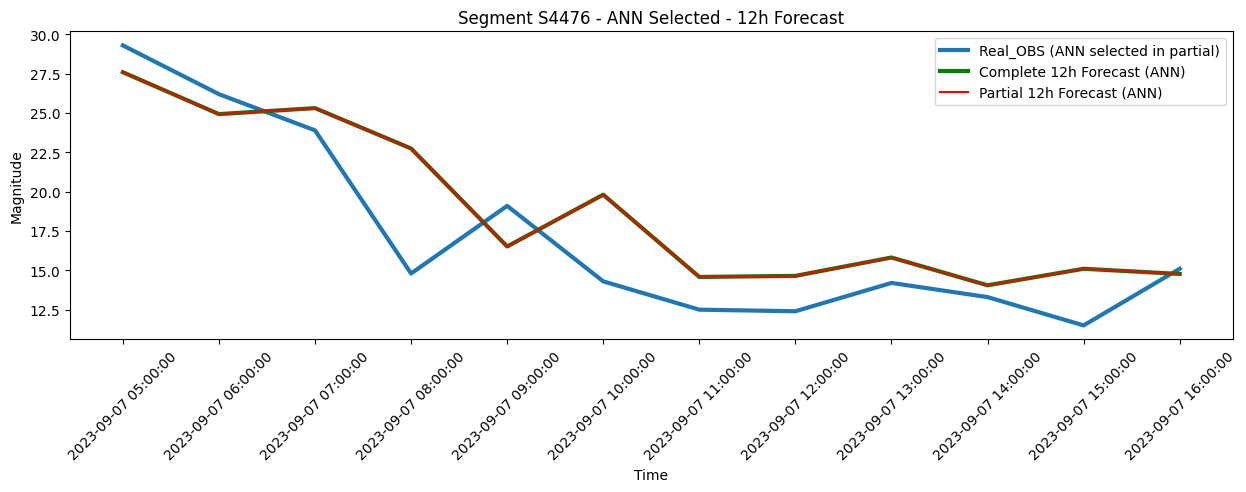

GRU


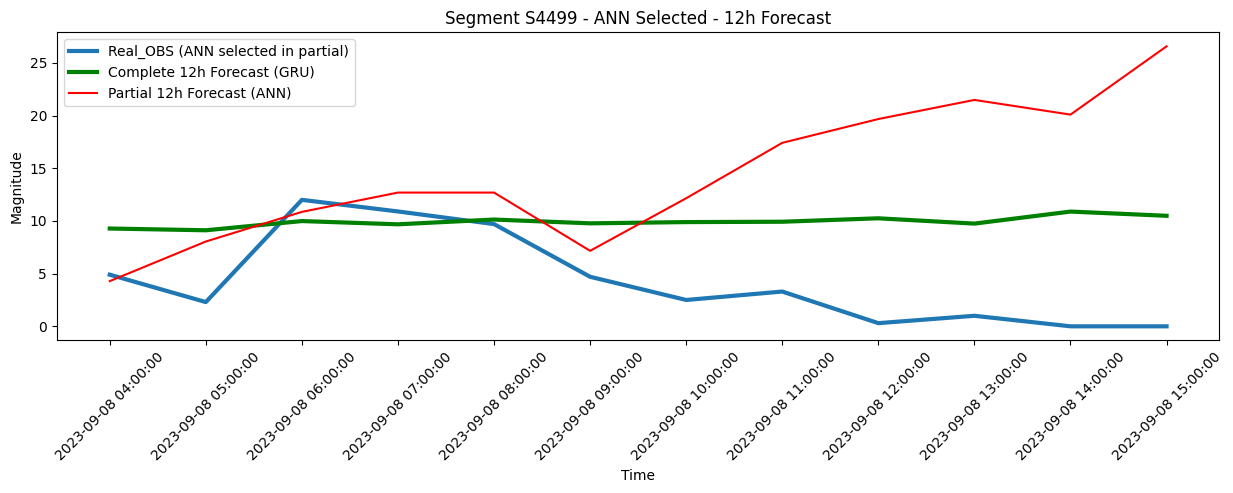

ANN


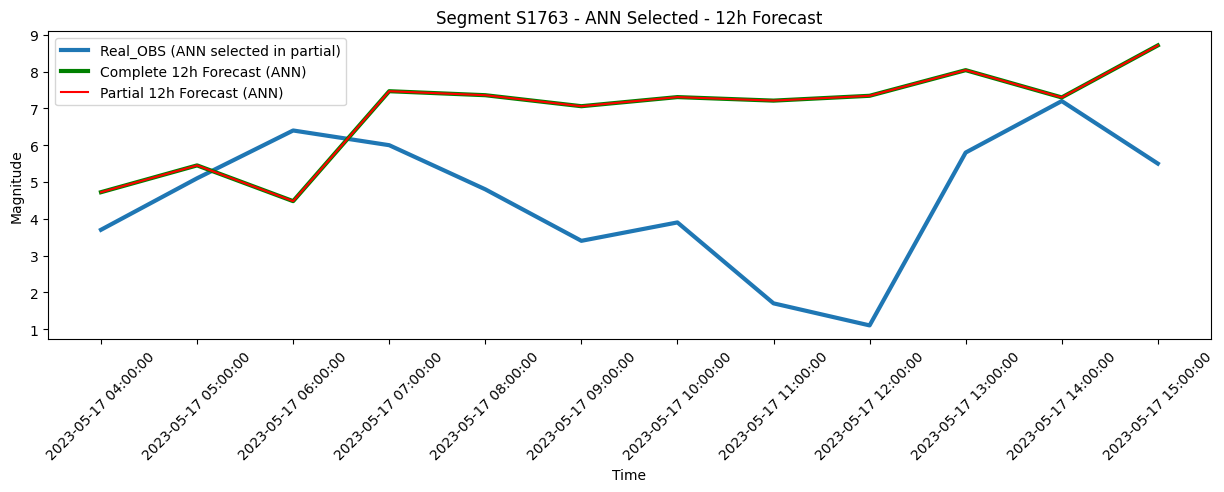

ANN


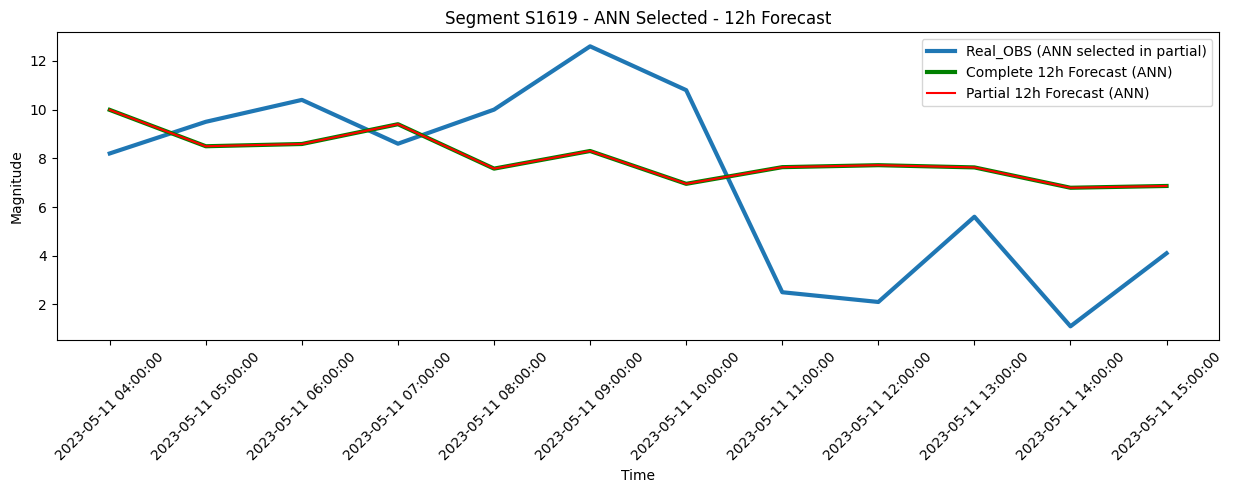

ANN


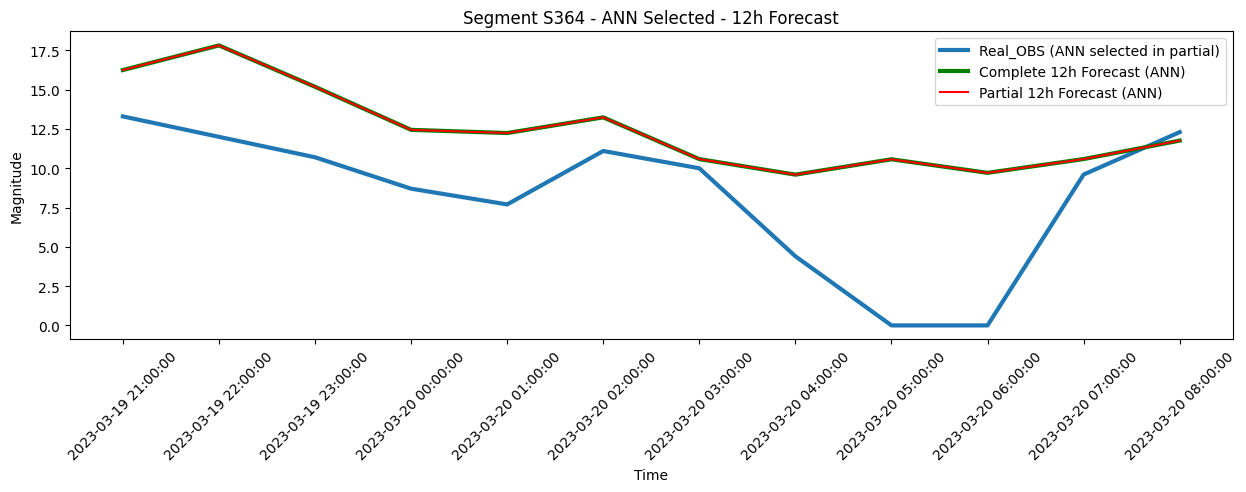

ANN


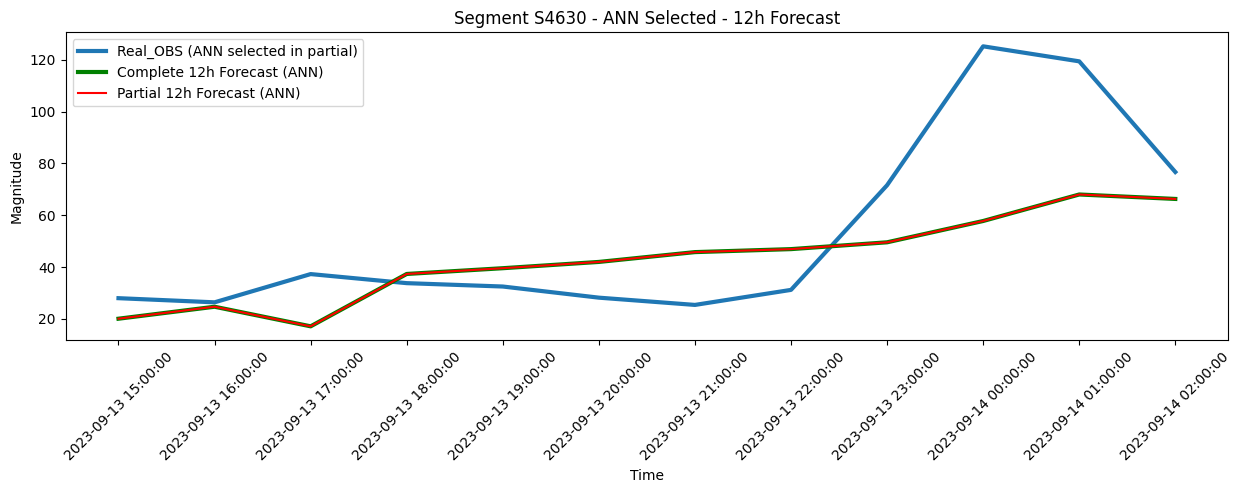

In [48]:
import pandas as pd
import matplotlib.pyplot as plt


forecasts_df = {}
y_test_df = {}
y_test_indices_df = {}
forecasts_complete_df = {}
for pred_length in pred_lengths:
    pred_length = str(pred_length)
    forecasts_df[pred_length] = {}
    y_test_df[pred_length] = {}
    y_test_indices_df[pred_length] = {}
    forecasts_complete_df[pred_length] = {}
    # Load the Dempster-Shafer complete ensemble file
    ensemble_complete_filepath = f"../../fusion/complete/forecast{pred_length}/dsi_ensemble_{pred_length}_{pred_length}_ID5_v3.csv"
    dsi_ensemble_complete = pd.read_csv(ensemble_complete_filepath, index_col="Segment")

    # Load the Dempster-Shafer ensemble file
    ensemble_filepath = f"../../fusion/partial/forecast{pred_length}/dsi_ensemble_{int(int(pred_length)/2)}_{pred_length}_ID5_v3.csv"
    dsi_ensemble = pd.read_csv(ensemble_filepath, index_col="Segment")
    unique_selected = dsi_ensemble["Selected"].unique()
    print(unique_selected)

    # Dictionary to hold top 10 segments for each selected model
    top_10_segments = {}

    for model in unique_selected:

        # Filter rows where the selected model is the current model
        selected_model_df = dsi_ensemble[dsi_ensemble["Selected"] == model]

        # Sort rows by the probability of the selected model and take the top 10
        top_10_segments[model] = selected_model_df.nlargest(10, model).index

        # Load forecasted values from CSV
        forecast_filepath = f"../../forecasts/forecast{pred_length}/LIVERPOOL_forecast_PM2.5_{seq_length}_{pred_length}_{model}.csv"
        forecasts_df[pred_length][model] = pd.read_csv(
            forecast_filepath, index_col="Segment"
        )

        # Load the corresponding true values (y_test)
        y_test_filepath = f"../../forecasts/test/test_data_forecast{pred_length}.csv"
        y_test_df[pred_length][model] = pd.read_csv(
            y_test_filepath, index_col="Segment"
        )

        y_test_indices_filepath = (
            f"../../forecasts/test/test_indices_forecast{pred_length}.csv"
        )
        y_test_indices_df[pred_length][model] = pd.read_csv(
            y_test_indices_filepath, index_col="Segment"
        )

        for segment in top_10_segments[model]:

            sample_number = int(
                segment[1:]
            )  # Remove 'S' and convert to integer for indexing
            # Load the forecast for the selected model in the partial ensemble
            partial_forecast = forecasts_df[pred_length][model].iloc[sample_number, :]

            # Load the forecast for the selected model in the complete ensemble
            complete_model = dsi_ensemble_complete.loc[segment, "Selected"]
            print(complete_model)
            forecast_complete_filepath = f"../../forecasts/forecast{pred_length}/LIVERPOOL_forecast_PM2.5_{seq_length}_{pred_length}_{complete_model}.csv"
            forecasts_complete_df[pred_length][complete_model] = pd.read_csv(
                forecast_complete_filepath, index_col="Segment"
            )

            complete_forecast = forecasts_complete_df[pred_length][complete_model].iloc[
                sample_number, :
            ]

            # Plot real observations
            plt.figure(figsize=(15, 4))
            plt.plot(
                y_test_indices_df[pred_length][model].iloc[sample_number, :],
                y_test_df[pred_length][model].iloc[sample_number, :],
                label=f"Real_OBS ({model} selected in partial)",
                linewidth=3,
            )

            # Plot forecast for the selected model in complete ensemble
            plt.plot(
                y_test_indices_df[pred_length][model].iloc[sample_number, :],
                complete_forecast,
                markersize=10,
                label=f"Complete {pred_length}h Forecast ({complete_model})",
                linewidth=3,
                color="green",
            )

            # Plot forecast for the selected model in partial ensemble
            plt.plot(
                y_test_indices_df[pred_length][model].iloc[sample_number, :],
                partial_forecast,
                markersize=10,
                label=f"Partial {pred_length}h Forecast ({model})",
                color="red",
            )

            if pred_length == "6":
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=45)
            plt.title(f"Segment {segment} - {model} Selected - {pred_length}h Forecast")
            plt.xlabel("Time")
            plt.ylabel("Magnitude")
            plt.legend()
            plt.show()


In [ ]:
forecasts_df = {}
y_test_df = {}
y_test_indices_df = {}

for pred_length in pred_lengths:
    pred_length = str(pred_length)
    forecasts_df[pred_length] = {}
    y_test_df[pred_length] = {}
    y_test_indices_df[pred_length] = {}
    for model in model_names:
        # Load forecasted values from CSV
        forecast_filepath = f"../../forecasts/forecast{pred_length}/LIVERPOOL_forecast_PM2.5_{seq_length}_{pred_length}_{model}.csv"
        forecasts_df[pred_length][model] = pd.read_csv(
            forecast_filepath, index_col="Segment"
        )

        # Load the corresponding true values (y_test)
        y_test_filepath = f"../../forecasts/test/test_data_forecast{pred_length}.csv"
        y_test_df[pred_length][model] = pd.read_csv(
            y_test_filepath, index_col="Segment"
        )

        y_test_indices_filepath = (
            f"../../forecasts/test/test_indices_forecast{pred_length}.csv"
        )
        y_test_indices_df[pred_length][model] = pd.read_csv(
            y_test_indices_filepath, index_col="Segment"
        )


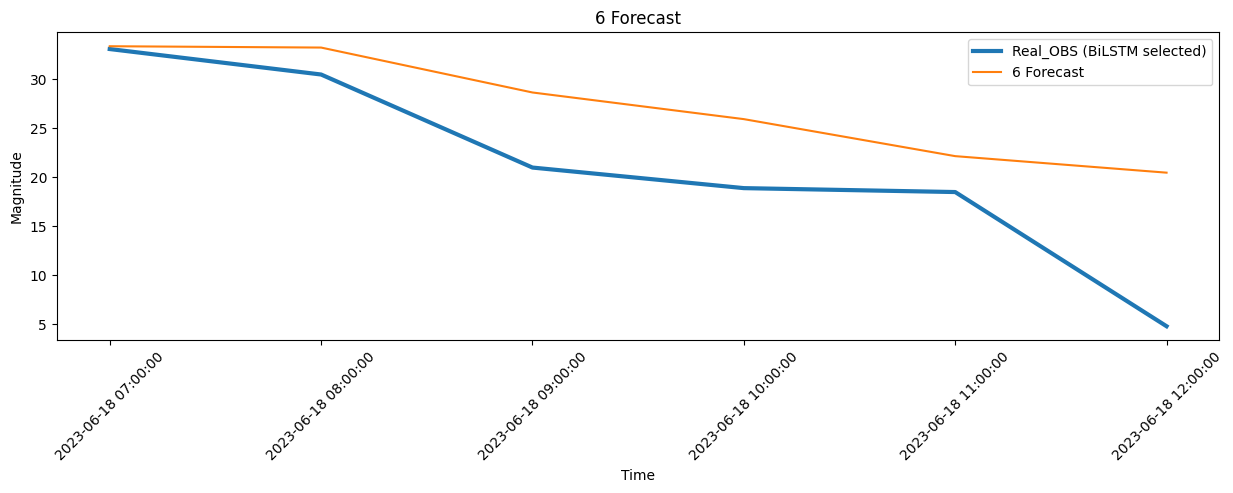

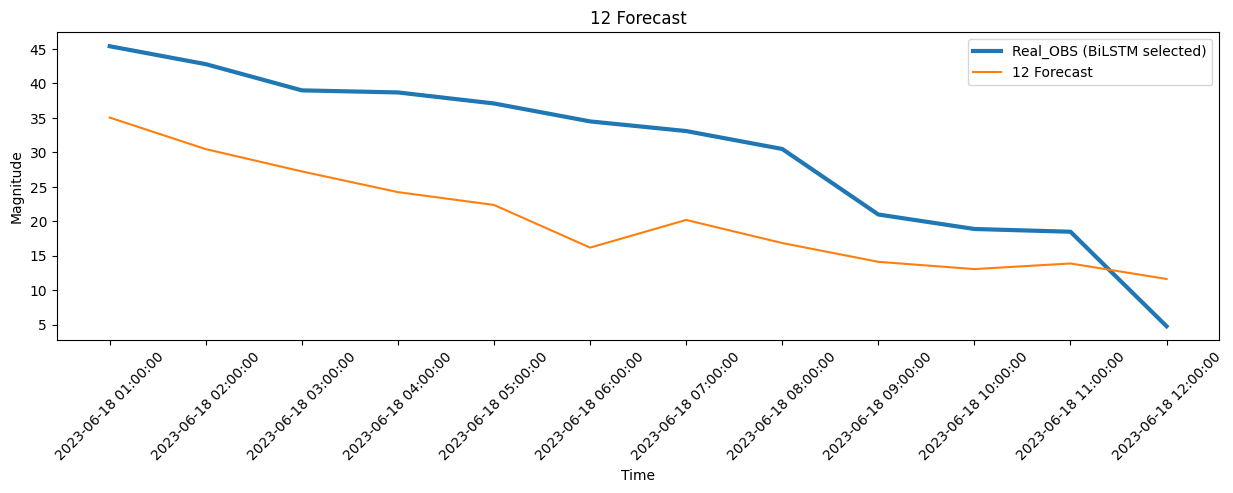

In [ ]:
pred_lengths = [6, 12]
sample_number = 2528  # 4475  #
model_name = "CNN-LSTM"
for forecast_length in pred_lengths:
    plt.figure(figsize=(15, 4))
    plt.plot(
        y_test_indices_df[f"{forecast_length}"][model_name].iloc[sample_number, :],
        y_test_df[f"{forecast_length}"][model_name].iloc[sample_number, :],
        label=f"Real_OBS ({model_name} selected)",
        linewidth=3,
    )

    forecast = forecasts_df[f"{forecast_length}"][model_name].iloc[sample_number, :]

    plt.plot(
        y_test_indices_df[f"{forecast_length}"][model_name].iloc[sample_number, :],
        forecast,
        markersize=10,
        label=f"{forecast_length} Forecast",
    )

    # plt.plot(data.index[-len(forecasts['LSTM']):], forecasts['LSTM'], marker='o', markersize=10,  label=f'Forecast', color = 'red')
    plt.xticks(rotation=45)
    plt.title(f"{forecast_length} Forecast")
    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.show()
